In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from scipy.optimize import minimize

plt.style.use('ggplot')
sns.set_theme()

# Part 1

In [2]:
# Read portfolio data
portfolios = pd.read_csv('initial_portfolio.csv')
portfolios.columns = ['Portfolio', 'Stock', 'Weight']  # Adjust column names according to provided information

# View portfolio data
print("Portfolio Data Preview:")
print(portfolios.head())

# View basic statistics of portfolios
print("\nNumber of Portfolios:", portfolios['Portfolio'].nunique())
portfolios_summary = portfolios.groupby('Portfolio').agg(
    Stock_Count=('Stock', 'count'),
    Total_Weight=('Weight', 'sum')
)
print("\nPortfolio Summary:")
print(portfolios_summary)

################################################################
# Read daily price data
prices = pd.read_csv('DailyPrices.csv')

# Convert date column to datetime format
prices['Date'] = pd.to_datetime(prices['Date'])
prices.set_index('Date', inplace=True)

# View price data
print("\nPrice Data Preview:")
print(prices.head())
print("\nPrice Data Shape:", prices.shape)


##############################################################
# Read risk-free rate data
rf = pd.read_csv('rf.csv')

# Convert date column to datetime format
rf['Date'] = pd.to_datetime(rf['Date'])
rf.set_index('Date', inplace=True)

# Convert percentage to decimal
rf['rf'] = rf['rf'] / 100

# View risk-free rate data
print("\nRisk-Free Rate Data Preview:")
print(rf.head())

Portfolio Data Preview:
  Portfolio Stock  Weight
0         A   WFC   142.0
1         A   ETN    30.0
2         A  AMZN    46.0
3         A  QCOM    64.0
4         A   LMT    21.0

Number of Portfolios: 3

Portfolio Summary:
           Stock_Count  Total_Weight
Portfolio                           
A                   33        3021.0
B                   33        2335.0
C                   33        1939.0

Price Data Preview:
                   SPY        AAPL       NVDA        MSFT       AMZN  \
Date                                                                   
2023-01-03  370.367920  123.768456  14.304595  236.183502  85.820000   
2023-01-04  373.227142  125.045052  14.738281  225.852097  85.139999   
2023-01-05  368.967438  123.718987  14.254632  219.158371  83.120003   
2023-01-06  377.428589  128.271118  14.848200  221.741211  86.080002   
2023-01-09  377.214661  128.795578  15.616640  223.900162  87.360001   

                  META      GOOGL       AVGO        TSLA       G

In [3]:

returns = prices.pct_change().dropna()

print("\nReturns Data Preview:")
print(returns.head())



Returns Data Preview:
                 SPY      AAPL      NVDA      MSFT      AMZN      META  \
Date                                                                     
2023-01-04  0.007720  0.010314  0.030318 -0.043743 -0.007924  0.021084   
2023-01-05 -0.011413 -0.010605 -0.032816 -0.029638 -0.023726 -0.003376   
2023-01-06  0.022932  0.036794  0.041640  0.011785  0.035611  0.024263   
2023-01-09 -0.000567  0.004089  0.051753  0.009736  0.014870 -0.004230   
2023-01-10  0.007013  0.004456  0.017981  0.007617  0.028732  0.027188   

               GOOGL      AVGO      TSLA      GOOG  ...      SBUX       MMC  \
Date                                                ...                       
2023-01-04 -0.011670  0.012214  0.051249 -0.011037  ...  0.036001  0.019460   
2023-01-05 -0.021344 -0.009318 -0.029039 -0.021869  ... -0.000287 -0.018143   
2023-01-06  0.013225  0.060196  0.024651  0.016019  ...  0.021641  0.029012   
2023-01-09  0.007786 -0.019612  0.059349  0.007260  ... -0.0182

In [4]:
end_of_2023 = returns[returns.index.year <= 2023].index[-1]
print(f"\nEnd of 2023 Date: {end_of_2023}")

regression_period = returns[returns.index <= end_of_2023]
holding_period = returns[returns.index > end_of_2023]

print(f"Regression Period: {regression_period.index[0]} to {regression_period.index[-1]}")
print(f"Holding Period: {holding_period.index[0]} to {holding_period.index[-1]}")
print(f"Regression Period Days: {len(regression_period)}")
print(f"Holding Period Days: {len(holding_period)}")


End of 2023 Date: 2023-12-29 00:00:00
Regression Period: 2023-01-04 00:00:00 to 2023-12-29 00:00:00
Holding Period: 2024-01-02 00:00:00 to 2025-01-03 00:00:00
Regression Period Days: 249
Holding Period Days: 254



CAPM Regression Results Preview:
  Stock     alpha      beta  r_squared       p_value   std_err
0   WFC -0.000189  1.140088   0.289900  4.053501e-20  0.113534
1   ETN  0.000815  1.113597   0.303543  3.610769e-21  0.107329
2  AMZN  0.000999  1.537007   0.371209  1.078935e-26  0.127283
3  QCOM  0.000044  1.483601   0.382640  1.102761e-27  0.119906
4   LMT -0.000352  0.317445   0.052900  2.519412e-04  0.085465
CAPM regression results successfully saved to capm_regression_results.csv


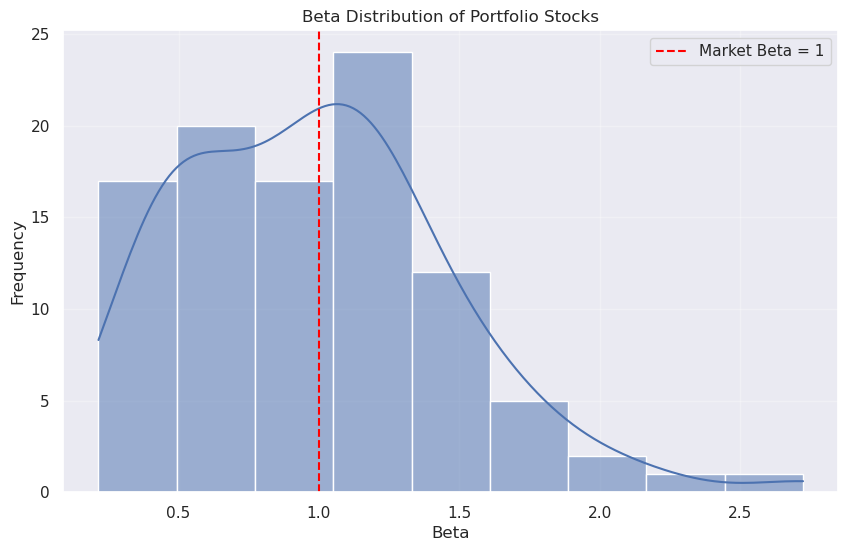

In [5]:
def capm_regression(stock_returns, market_returns, risk_free_rate):

    excess_stock = stock_returns - risk_free_rate
    excess_market = market_returns - risk_free_rate
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(excess_market, excess_stock)
    
    return {
        'alpha': intercept,
        'beta': slope,
        'r_squared': r_value**2,
        'p_value': p_value,
        'std_err': std_err
    }

def save_capm_results_to_csv(capm_df, filename='capm_regression_results.csv'):
    try:
        df_to_save = capm_df.copy()
        df_to_save = df_to_save.rename(columns={
            'alpha': 'Alpha',
            'beta': 'Beta',
            'r_squared': 'R_Squared',
            'p_value': 'P_Value',
            'std_err': 'Standard_Error'
        })
        
        # Save results to CSV file
        df_to_save.to_csv(filename, index=False)
        print(f"CAPM regression results successfully saved to {filename}")
        
    except Exception as e:
        print(f"Error saving results to CSV: {e}")
        
# Align risk-free rate with returns data
aligned_rf = rf.reindex(regression_period.index)

# Execute CAPM regression for each stock in the portfolios
capm_results = {}
stocks_in_portfolios = portfolios['Stock'].unique()

for stock in stocks_in_portfolios:
    if stock in regression_period.columns:
        capm_result = capm_regression(
            regression_period[stock],
            regression_period['SPY'],
            aligned_rf['rf']
        )
        capm_results[stock] = capm_result
    else:
        print(f"Warning: {stock} does not exist in the price data")

# View CAPM regression results
capm_df = pd.DataFrame(capm_results).T
capm_df.index.name = 'Stock'
capm_df = capm_df.reset_index()

print("\nCAPM Regression Results Preview:")
print(capm_df.head())
save_capm_results_to_csv(capm_df) 

# Plot beta distribution
plt.figure(figsize=(10, 6))
sns.histplot(capm_df['beta'], kde=True)
plt.title('Beta Distribution of Portfolio Stocks')
plt.xlabel('Beta')
plt.ylabel('Frequency')
plt.axvline(x=1, color='red', linestyle='--', label='Market Beta = 1')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [6]:
# Align risk-free rate with holding period
holding_rf = rf.reindex(holding_period.index)

# Calculate cumulative returns during the holding period
cumulative_returns = (1 + holding_period).cumprod() - 1
final_returns = cumulative_returns.iloc[-1]

# Create a function to calculate systematic and idiosyncratic returns during the holding period
def calculate_return_attribution(stock, beta, alpha, market_returns, risk_free_rate):
    """
    Calculate the systematic and idiosyncratic components of stock returns
    
    Parameters:
    stock: Stock name
    beta: Stock's beta value
    alpha: Stock's alpha value
    market_returns: Market returns series
    risk_free_rate: Risk-free rate series
    
    Returns:
    systematic_return: Systematic return
    idiosyncratic_return: Idiosyncratic return
    total_return: Total return
    """
    # Calculate daily systematic and idiosyncratic returns
    daily_systematic = beta * (market_returns - risk_free_rate) + risk_free_rate
    daily_total = holding_period[stock]
    daily_idiosyncratic = daily_total - daily_systematic
    
    # Calculate cumulative returns
    cumulative_systematic = (1 + daily_systematic).cumprod() - 1
    cumulative_idiosyncratic = (1 + daily_idiosyncratic).cumprod() - 1
    cumulative_total = (1 + daily_total).cumprod() - 1
    
    # Get final cumulative returns
    final_systematic = cumulative_systematic.iloc[-1]
    final_idiosyncratic = cumulative_idiosyncratic.iloc[-1]
    final_total = cumulative_total.iloc[-1]
    
    return {
        'systematic_return': final_systematic,
        'idiosyncratic_return': final_idiosyncratic,
        'total_return': final_total
    }

# Calculate return attribution for each stock
return_attribution = {}

for stock in stocks_in_portfolios:
    if stock in holding_period.columns and stock in capm_results:
        beta = capm_results[stock]['beta']
        alpha = capm_results[stock]['alpha']
        
        attribution = calculate_return_attribution(
            stock,
            beta,
            alpha,
            holding_period['SPY'],
            holding_rf['rf']
        )
        
        return_attribution[stock] = attribution
    elif stock not in holding_period.columns:
        print(f"Warning: {stock} does not exist in the holding period price data")

# Convert return attribution results to DataFrame
attribution_df = pd.DataFrame(return_attribution).T
attribution_df.index.name = 'Stock'
attribution_df = attribution_df.reset_index()

print("\nStock Return Attribution Results Preview:")
print(attribution_df.head())


Stock Return Attribution Results Preview:
  Stock  systematic_return  idiosyncratic_return  total_return
0   WFC           0.301307              0.136159      0.487094
1   ETN           0.293691              0.123467      0.440136
2  AMZN           0.419004              0.040192      0.475517
3  QCOM           0.402776             -0.197798      0.112787
4   LMT           0.078753              0.003356      0.084088


In [7]:
# Merge CAPM results and return attribution results
merged_results = pd.merge(
    capm_df,
    attribution_df,
    on='Stock',
    how='inner'
)

print("\nMerged Results Preview:")
print(merged_results.head())

# Calculate portfolio systematic and idiosyncratic return attribution
# First, we need to normalize the Weight column in the portfolio data
portfolios_normalized = portfolios.copy()

# Normalize weights within each portfolio
for portfolio_name in portfolios_normalized['Portfolio'].unique():
    portfolio_mask = portfolios_normalized['Portfolio'] == portfolio_name
    total_weight = portfolios_normalized.loc[portfolio_mask, 'Weight'].sum()
    portfolios_normalized.loc[portfolio_mask, 'Weight'] = portfolios_normalized.loc[portfolio_mask, 'Weight'] / total_weight

print("\nNormalized Portfolio Weights:")
print(portfolios_normalized.groupby('Portfolio')['Weight'].sum())  # Confirm that the sum of weights for each portfolio is 1


Merged Results Preview:
  Stock     alpha      beta  r_squared       p_value   std_err  \
0   WFC -0.000189  1.140088   0.289900  4.053501e-20  0.113534   
1   ETN  0.000815  1.113597   0.303543  3.610769e-21  0.107329   
2  AMZN  0.000999  1.537007   0.371209  1.078935e-26  0.127283   
3  QCOM  0.000044  1.483601   0.382640  1.102761e-27  0.119906   
4   LMT -0.000352  0.317445   0.052900  2.519412e-04  0.085465   

   systematic_return  idiosyncratic_return  total_return  
0           0.301307              0.136159      0.487094  
1           0.293691              0.123467      0.440136  
2           0.419004              0.040192      0.475517  
3           0.402776             -0.197798      0.112787  
4           0.078753              0.003356      0.084088  

Normalized Portfolio Weights:
Portfolio
A    1.0
B    1.0
C    1.0
Name: Weight, dtype: float64


In [8]:
# Calculate systematic and idiosyncratic returns for each portfolio
portfolio_attribution = []

for portfolio_name in portfolios_normalized['Portfolio'].unique():
    # Get portfolio stocks and weights
    portfolio_stocks = portfolios_normalized[portfolios_normalized['Portfolio'] == portfolio_name]
    
    # Join with merged results to get CAPM parameters and attribution results for each stock
    portfolio_data = pd.merge(
        portfolio_stocks,
        merged_results,
        left_on='Stock',
        right_on='Stock',
        how='inner'
    )
    
    # Print warning if stocks are missing data
    missing_stocks = set(portfolio_stocks['Stock']) - set(portfolio_data['Stock'])
    if missing_stocks:
        print(f"Warning: {missing_stocks} in portfolio {portfolio_name} are missing from merged results")
    
    # Calculate portfolio-level metrics
    if not portfolio_data.empty:
        portfolio_beta = (portfolio_data['beta'] * portfolio_data['Weight']).sum()
        portfolio_alpha = (portfolio_data['alpha'] * portfolio_data['Weight']).sum()
        portfolio_systematic_return = (portfolio_data['systematic_return'] * portfolio_data['Weight']).sum()
        portfolio_idiosyncratic_return = (portfolio_data['idiosyncratic_return'] * portfolio_data['Weight']).sum()
        portfolio_total_return = (portfolio_data['total_return'] * portfolio_data['Weight']).sum()
        
        # Calculate covered weight (proportion of weights actually included in calculation)
        covered_weight = portfolio_data['Weight'].sum()
        
        # Calculate component proportions
        systematic_proportion = portfolio_systematic_return / portfolio_total_return if portfolio_total_return != 0 else 0
        idiosyncratic_proportion = portfolio_idiosyncratic_return / portfolio_total_return if portfolio_total_return != 0 else 0
        
        # Store results
        portfolio_attribution.append({
            'Portfolio': portfolio_name,
            'Beta': portfolio_beta,
            'Alpha': portfolio_alpha,
            'Total_Return': portfolio_total_return,
            'Systematic_Return': portfolio_systematic_return,
            'Idiosyncratic_Return': portfolio_idiosyncratic_return,
            'Systematic_Proportion': systematic_proportion,
            'Idiosyncratic_Proportion': idiosyncratic_proportion,
            'Covered_Weight': covered_weight
        })
    else:
        print(f"Warning: No valid data for portfolio {portfolio_name}")

# Convert to DataFrame
portfolio_attribution_df = pd.DataFrame(portfolio_attribution)

print("\nPortfolio Return Attribution Results:")
print(portfolio_attribution_df)


Portfolio Return Attribution Results:
  Portfolio      Beta     Alpha  Total_Return  Systematic_Return  \
0         A  0.949232 -0.000071      0.184326           0.251480   
1         B  0.704469 -0.000602      0.248237           0.182378   
2         C  1.104456  0.000440      0.500267           0.298922   

   Idiosyncratic_Return  Systematic_Proportion  Idiosyncratic_Proportion  \
0             -0.056499               1.364322                 -0.306517   
1              0.060642               0.734694                  0.244292   
2              0.119171               0.597526                  0.238215   

   Covered_Weight  
0             1.0  
1             1.0  
2             1.0  


In [9]:
# Calculate overall attribution results for all portfolios (total portfolio)
# For this, we need to know the weight of each portfolio in the total investment
# Assume all portfolios have equal weight, or adjust according to actual situation

# Calculate the weight of each portfolio in the total investment (assuming equal weights here)
num_portfolios = len(portfolio_attribution_df)
equal_weight = 1.0 / num_portfolios

# Calculate metrics for the total portfolio
total_portfolio = {
    'Portfolio': 'TOTAL PORTFOLIO',
    'Beta': (portfolio_attribution_df['Beta'] * equal_weight).sum(),
    'Alpha': (portfolio_attribution_df['Alpha'] * equal_weight).sum() if 'Alpha' in portfolio_attribution_df.columns else 0,
    'Total_Return': (portfolio_attribution_df['Total_Return'] * equal_weight).sum(),
    'Systematic_Return': (portfolio_attribution_df['Systematic_Return'] * equal_weight).sum(),
    'Idiosyncratic_Return': (portfolio_attribution_df['Idiosyncratic_Return'] * equal_weight).sum(),
    'Systematic_Proportion': (portfolio_attribution_df['Systematic_Return'] * equal_weight).sum() / 
                           (portfolio_attribution_df['Total_Return'] * equal_weight).sum(),
    'Idiosyncratic_Proportion': (portfolio_attribution_df['Idiosyncratic_Return'] * equal_weight).sum() / 
                              (portfolio_attribution_df['Total_Return'] * equal_weight).sum(),
    'Covered_Weight': 1.0
}

# Add to results DataFrame
portfolio_attribution_df = pd.concat([
    portfolio_attribution_df, 
    pd.DataFrame([total_portfolio])
], ignore_index=True)

print("\nTotal Portfolio Return Attribution Results:")
print(portfolio_attribution_df)

# Save results to CSV
portfolio_attribution_df.to_csv('portfolio_attribution_results.csv', index=False)
print("Portfolio attribution results saved to 'portfolio_attribution_results.csv'")


Total Portfolio Return Attribution Results:
         Portfolio      Beta     Alpha  Total_Return  Systematic_Return  \
0                A  0.949232 -0.000071      0.184326           0.251480   
1                B  0.704469 -0.000602      0.248237           0.182378   
2                C  1.104456  0.000440      0.500267           0.298922   
3  TOTAL PORTFOLIO  0.919386 -0.000078      0.310943           0.244260   

   Idiosyncratic_Return  Systematic_Proportion  Idiosyncratic_Proportion  \
0             -0.056499               1.364322                 -0.306517   
1              0.060642               0.734694                  0.244292   
2              0.119171               0.597526                  0.238215   
3              0.041105               0.785546                  0.132194   

   Covered_Weight  
0             1.0  
1             1.0  
2             1.0  
3             1.0  
Portfolio attribution results saved to 'portfolio_attribution_results.csv'


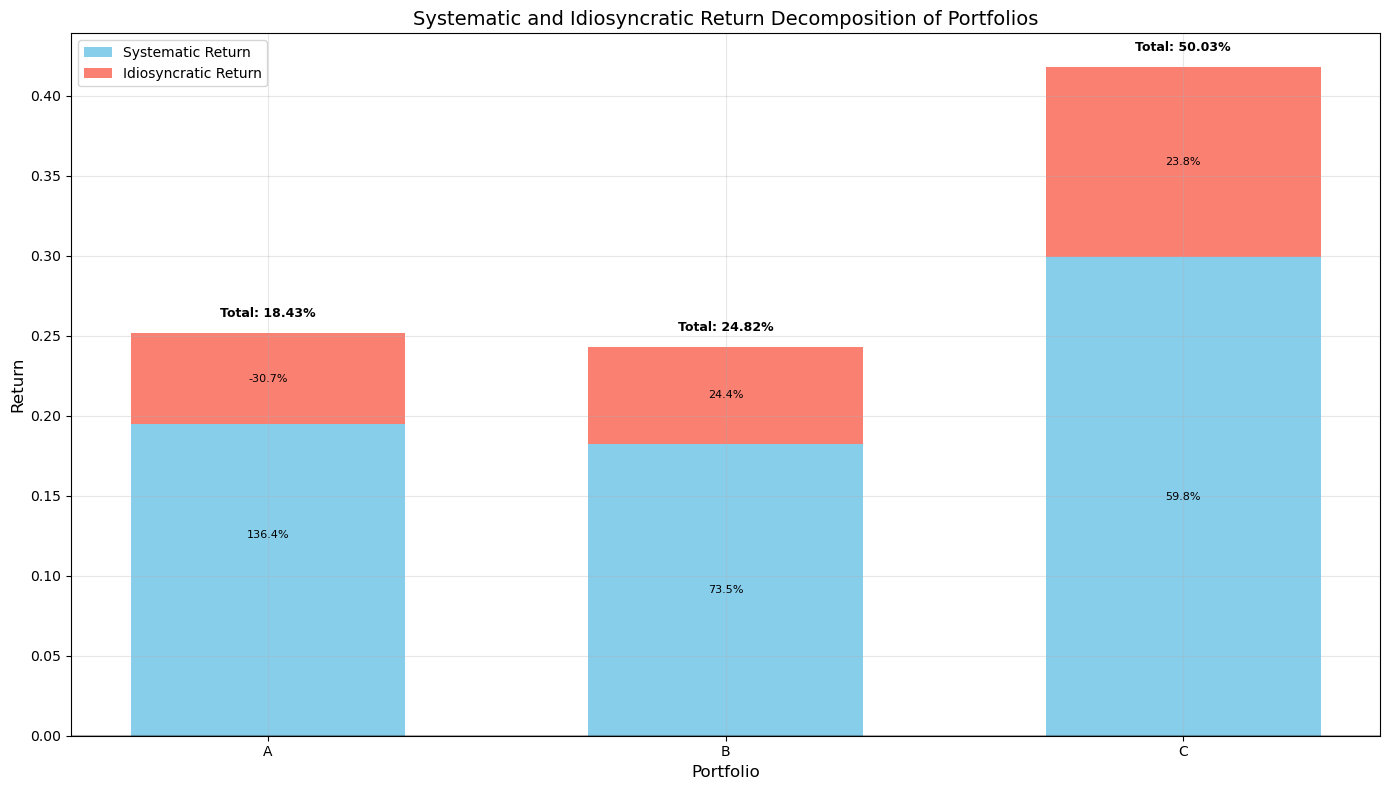

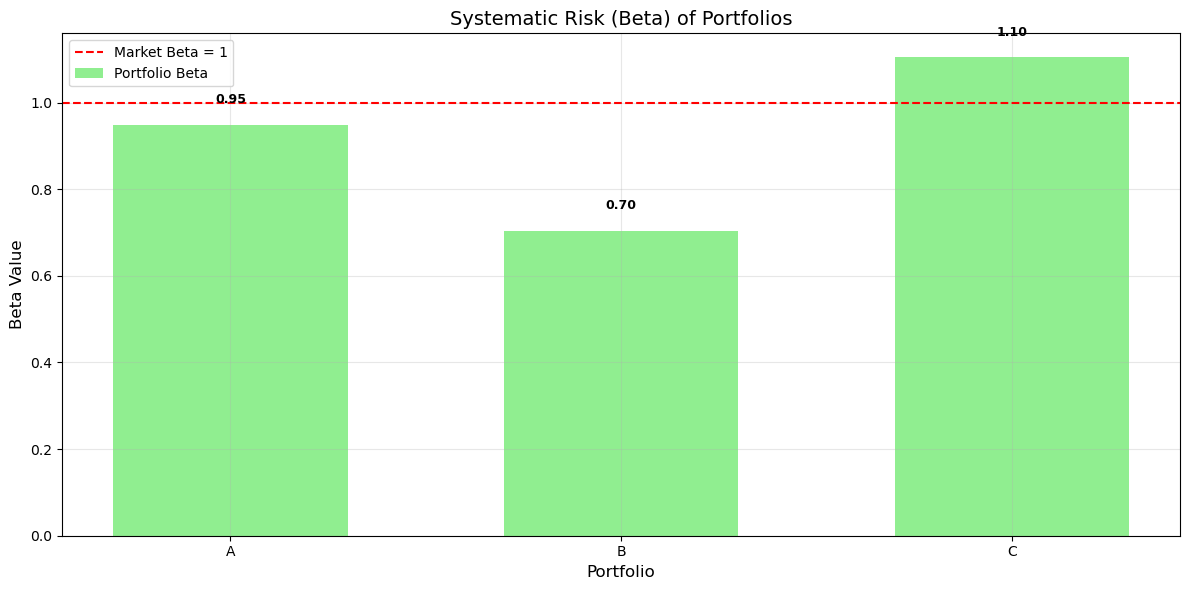

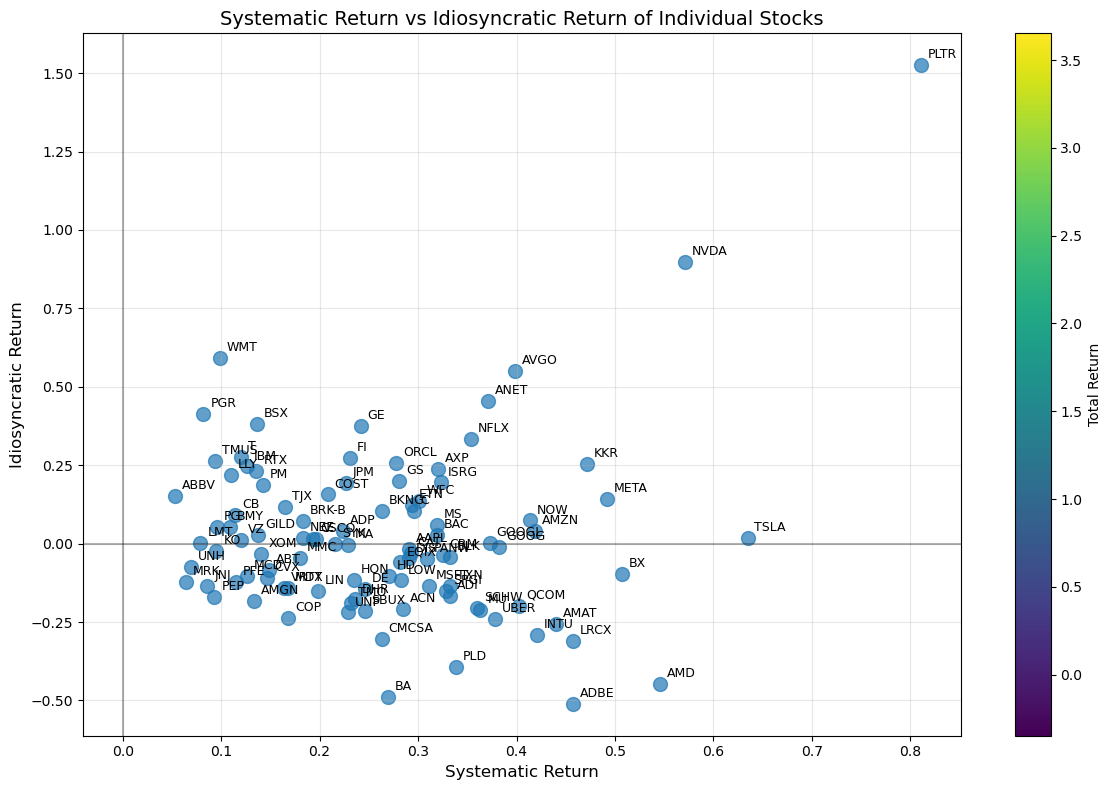


Detailed Stock Attribution Results (first few rows):
  Portfolio Stock    Weight      Beta     Alpha  R_Squared  Total_Return  \
0         A   WFC  0.047004  1.140088 -0.000189   0.289900      0.487094   
1         A   ETN  0.009930  1.113597  0.000815   0.303543      0.440136   
2         A  AMZN  0.015227  1.537007  0.000999   0.371209      0.475517   
3         A  QCOM  0.021185  1.483601  0.000044   0.382640      0.112787   
4         A   LMT  0.006951  0.317445 -0.000352   0.052900      0.084088   

   Systematic_Return  Idiosyncratic_Return  Weighted_Total_Return  \
0           0.301307              0.136159               0.022896   
1           0.293691              0.123467               0.004371   
2           0.419004              0.040192               0.007241   
3           0.402776             -0.197798               0.002389   
4           0.078753              0.003356               0.000585   

   Weighted_Systematic_Return  Weighted_Idiosyncratic_Return  
0          

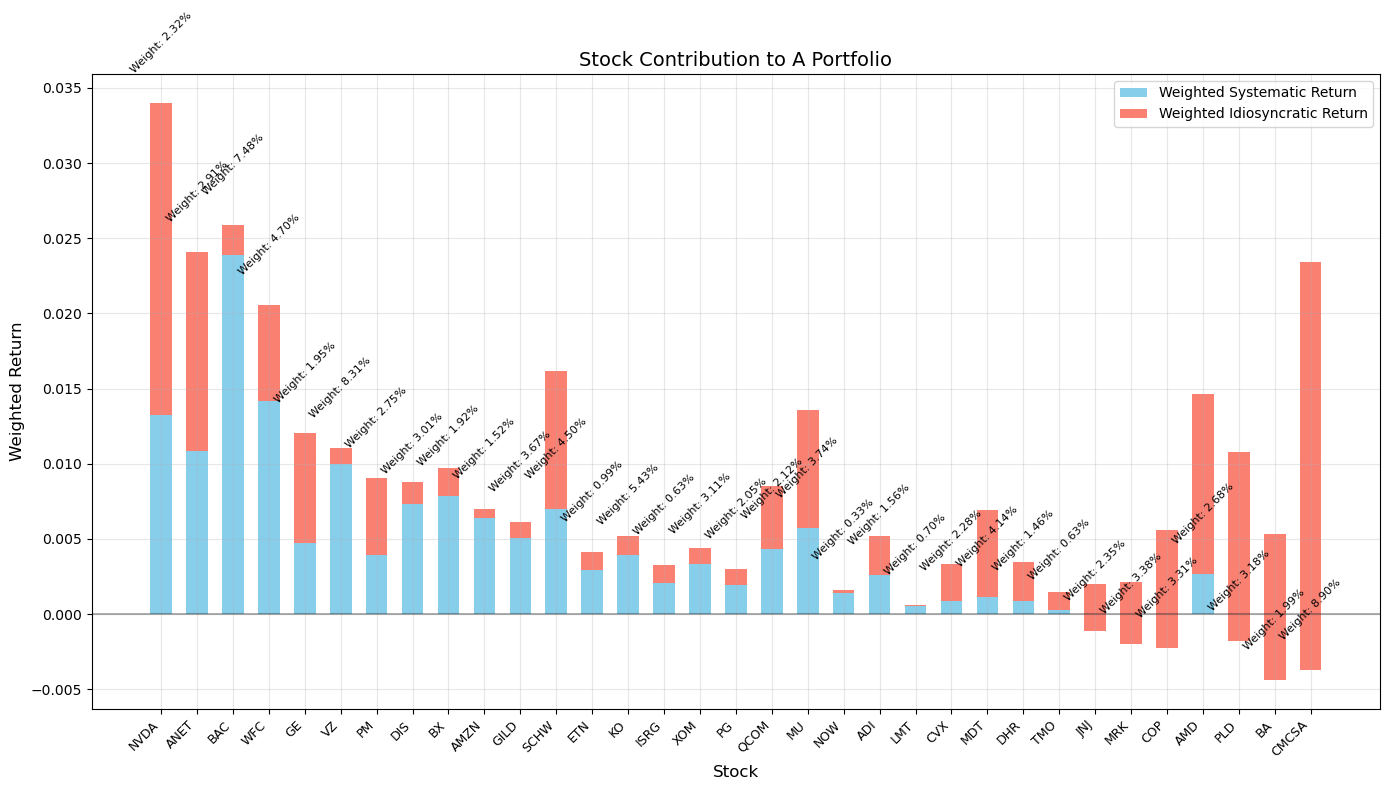

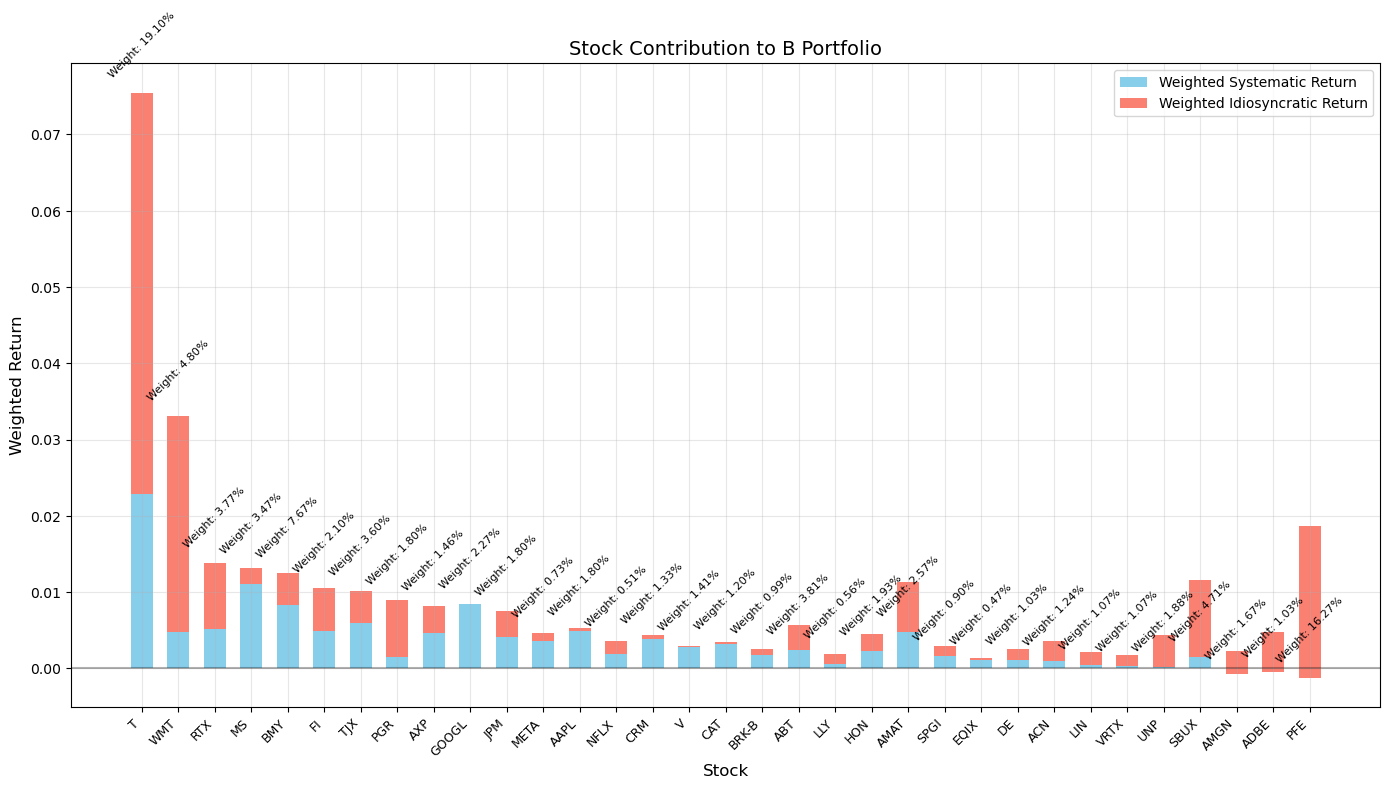

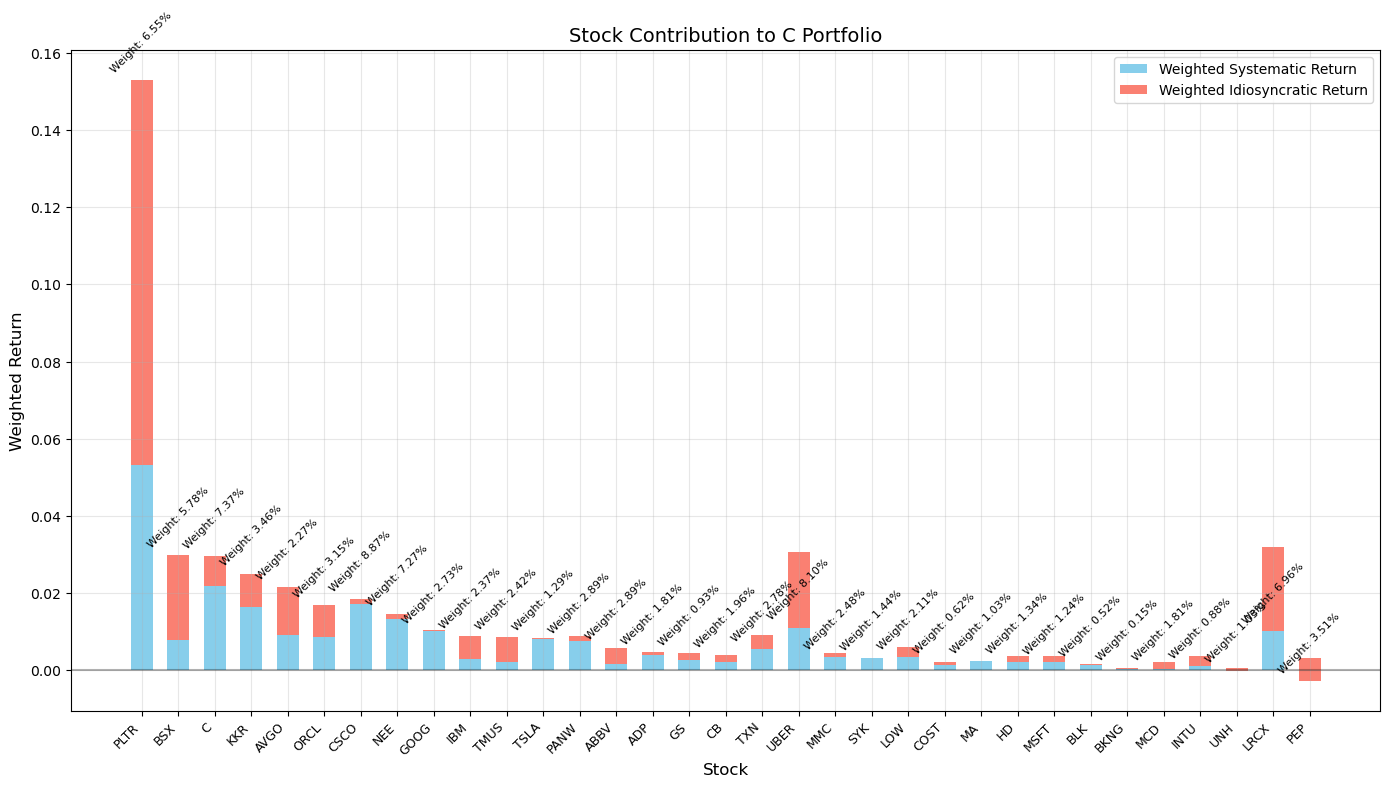


Analysis completed and visualizations saved.


In [ ]:
# Visualization: Plot the proportion of systematic and idiosyncratic returns of portfolios
plt.figure(figsize=(14, 8))

# Set portfolio labels (excluding TOTAL PORTFOLIO)
labels = portfolio_attribution_df['Portfolio'][:-1]  # Exclude the last row (total portfolio)

# Systematic and idiosyncratic return values
systematic_values = portfolio_attribution_df['Systematic_Return'][:-1]
idiosyncratic_values = portfolio_attribution_df['Idiosyncratic_Return'][:-1]
total_values = portfolio_attribution_df['Total_Return'][:-1]

# Create stacked bar chart
width = 0.6
x = np.arange(len(labels))

# Systematic returns (possibly negative)
plt.bar(x, systematic_values, width, label='Systematic Return', color='skyblue')

# Idiosyncratic returns (stacked on systematic returns)
plt.bar(x, idiosyncratic_values, width, bottom=systematic_values, label='Idiosyncratic Return', color='salmon')

plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.title('Systematic and Idiosyncratic Return Decomposition of Portfolios', fontsize=14)
plt.xlabel('Portfolio', fontsize=12)
plt.ylabel('Return', fontsize=12)
plt.xticks(x, labels, fontsize=10)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# Add total return labels
for i, (total, sys_ret, idio_ret) in enumerate(zip(total_values, systematic_values, idiosyncratic_values)):
    # Determine label position
    if idio_ret >= 0:
        label_position = systematic_values[i] + idiosyncratic_values[i] + 0.01
    else:
        # If idiosyncratic return is negative, place label above systematic return
        label_position = max(systematic_values[i], systematic_values[i] + idiosyncratic_values[i]) + 0.01
    
    plt.text(i, label_position, f'Total: {total:.2%}', ha='center', fontsize=9, fontweight='bold')
    
    # Add percentage labels for systematic and idiosyncratic returns
    sys_pct = sys_ret / total if total != 0 else 0
    idio_pct = idio_ret / total if total != 0 else 0
    
    # Only add labels when values are large enough
    if abs(sys_ret) > 0.01:
        plt.text(i, systematic_values[i]/2, f'{sys_pct:.1%}', ha='center', va='center', fontsize=8, color='black')
    
    if abs(idio_ret) > 0.01:
        y_pos = systematic_values[i] + idiosyncratic_values[i]/2
        plt.text(i, y_pos, f'{idio_pct:.1%}', ha='center', va='center', fontsize=8, color='black')

plt.tight_layout()
plt.savefig('portfolio_return_decomposition.png', dpi=300)
plt.show()

# Visualization: Plot portfolio Beta values
plt.figure(figsize=(12, 6))

# Exclude TOTAL PORTFOLIO
x = np.arange(len(labels))
beta_values = portfolio_attribution_df['Beta'][:-1]

plt.bar(x, beta_values, width, label='Portfolio Beta', color='lightgreen')
plt.axhline(y=1, color='red', linestyle='--', label='Market Beta = 1')

plt.title('Systematic Risk (Beta) of Portfolios', fontsize=14)
plt.xlabel('Portfolio', fontsize=12)
plt.ylabel('Beta Value', fontsize=12)
plt.xticks(x, labels, fontsize=10)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# Add beta value labels
for i, beta in enumerate(beta_values):
    plt.text(i, beta + 0.05, f'{beta:.2f}', ha='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('portfolio_beta_values.png', dpi=300)
plt.show()

# Visualization: Scatter plot of idiosyncratic return vs systematic return (stock level)
plt.figure(figsize=(12, 8))

# Draw scatter plot
plt.scatter(
    merged_results['systematic_return'],
    merged_results['idiosyncratic_return'],
    alpha=0.7,
    s=100  # Increase point size
)

# Add reference lines
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)

# Add text labels
for i, row in merged_results.iterrows():
    plt.annotate(
        row['Stock'],
        (row['systematic_return'], row['idiosyncratic_return']),
        fontsize=9,
        xytext=(5, 5),
        textcoords='offset points'
    )

plt.title('Systematic Return vs Idiosyncratic Return of Individual Stocks', fontsize=14)
plt.xlabel('Systematic Return', fontsize=12)
plt.ylabel('Idiosyncratic Return', fontsize=12)
plt.grid(True, alpha=0.3)

# Add color mapping for total return and Beta
plt.colorbar(
    plt.scatter(
        merged_results['systematic_return'],
        merged_results['idiosyncratic_return'],
        c=merged_results['total_return'],
        s=0  # Make this scatter invisible, only used for colorbar
    ),
    label='Total Return'
)

plt.tight_layout()
plt.savefig('stock_return_attribution_scatter.png', dpi=300)
plt.show()

# Calculate detailed stock-level attribution results (each stock within each portfolio)
detailed_attribution = []

for _, portfolio_row in portfolios_normalized.iterrows():
    portfolio_name = portfolio_row['Portfolio']
    stock = portfolio_row['Stock']
    weight = portfolio_row['Weight']
    
    # Get CAPM parameters and attribution results for this stock
    stock_data = merged_results[merged_results['Stock'] == stock]
    
    if not stock_data.empty:
        stock_data = stock_data.iloc[0]
        
        # Calculate this stock's contribution to the portfolio
        weighted_systematic_return = weight * stock_data['systematic_return']
        weighted_idiosyncratic_return = weight * stock_data['idiosyncratic_return']
        weighted_total_return = weight * stock_data['total_return']
        
        # Store results
        detailed_attribution.append({
            'Portfolio': portfolio_name,
            'Stock': stock,
            'Weight': weight,
            'Beta': stock_data['beta'],
            'Alpha': stock_data['alpha'],
            'R_Squared': stock_data['r_squared'],
            'Total_Return': stock_data['total_return'],
            'Systematic_Return': stock_data['systematic_return'],
            'Idiosyncratic_Return': stock_data['idiosyncratic_return'],
            'Weighted_Total_Return': weighted_total_return,
            'Weighted_Systematic_Return': weighted_systematic_return,
            'Weighted_Idiosyncratic_Return': weighted_idiosyncratic_return
        })
    else:
        print(f"Warning: No data for {stock} in portfolio {portfolio_name}")

# Convert to DataFrame
detailed_attribution_df = pd.DataFrame(detailed_attribution)

print("\nDetailed Stock Attribution Results (first few rows):")
print(detailed_attribution_df.head())

# Save detailed results to CSV
detailed_attribution_df.to_csv('detailed_stock_attribution_results.csv', index=False)
print("Detailed stock attribution results saved to 'detailed_stock_attribution_results.csv'")

# Visualization: Stock contributions in each portfolio
for portfolio_name in detailed_attribution_df['Portfolio'].unique():
    # Get stock data for this portfolio
    portfolio_data = detailed_attribution_df[detailed_attribution_df['Portfolio'] == portfolio_name]
    
    # Sort by weighted total return
    portfolio_data = portfolio_data.sort_values('Weighted_Total_Return', ascending=False)
    
    plt.figure(figsize=(14, 8))
    
    # Set stock labels
    labels = portfolio_data['Stock']
    
    # Weighted systematic and idiosyncratic return values
    weighted_systematic = portfolio_data['Weighted_Systematic_Return']
    weighted_idiosyncratic = portfolio_data['Weighted_Idiosyncratic_Return']
    
    # Create stacked bar chart
    width = 0.6
    x = np.arange(len(labels))
    
    plt.bar(x, weighted_systematic, width, label='Weighted Systematic Return', color='skyblue')
    plt.bar(x, weighted_idiosyncratic, width, bottom=weighted_systematic, label='Weighted Idiosyncratic Return', color='salmon')
    
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.title(f'Stock Contribution to {portfolio_name} Portfolio', fontsize=14)
    plt.xlabel('Stock', fontsize=12)
    plt.ylabel('Weighted Return', fontsize=12)
    plt.xticks(x, labels, rotation=45, ha='right', fontsize=9)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # Add total weight labels
    for i, row in enumerate(portfolio_data.itertuples()):
        plt.text(i, row.Weighted_Systematic_Return + row.Weighted_Idiosyncratic_Return + 0.002, 
                f'Weight: {row.Weight:.2%}', ha='center', fontsize=8, rotation=45)
    
    plt.tight_layout()
    plt.savefig(f'{portfolio_name}_stock_contributions.png', dpi=300)
    plt.show()

print("\nAnalysis completed and visualizations saved.")

# 6. 计算系统性和非系统性风险归因


Market Return Variance: 0.000068

Calculating risk attribution for each stock...

Stock Risk Attribution Results (First 5 rows):
  Stock      beta  systematic_risk  idiosyncratic_risk  total_risk
0   WFC  1.140088         0.000088            0.000217    0.000305
1   ETN  1.113597         0.000084            0.000194    0.000278
2  AMZN  1.537007         0.000161            0.000272    0.000433
3  QCOM  1.483601         0.000150            0.000242    0.000391
4   LMT  0.317445         0.000007            0.000123    0.000130

Calculating portfolio risk attribution...

Portfolio Risk Attribution Results:
  Portfolio      Beta  Total_Risk  Systematic_Risk  Idiosyncratic_Risk  \
0         A  0.949232    0.000085         0.000075            0.000010   
1         B  0.704469    0.000060         0.000042            0.000018   
2         C  1.104456    0.000124         0.000108            0.000016   

   Systematic_Risk_Proportion  Idiosyncratic_Risk_Proportion  
0                    0.88543

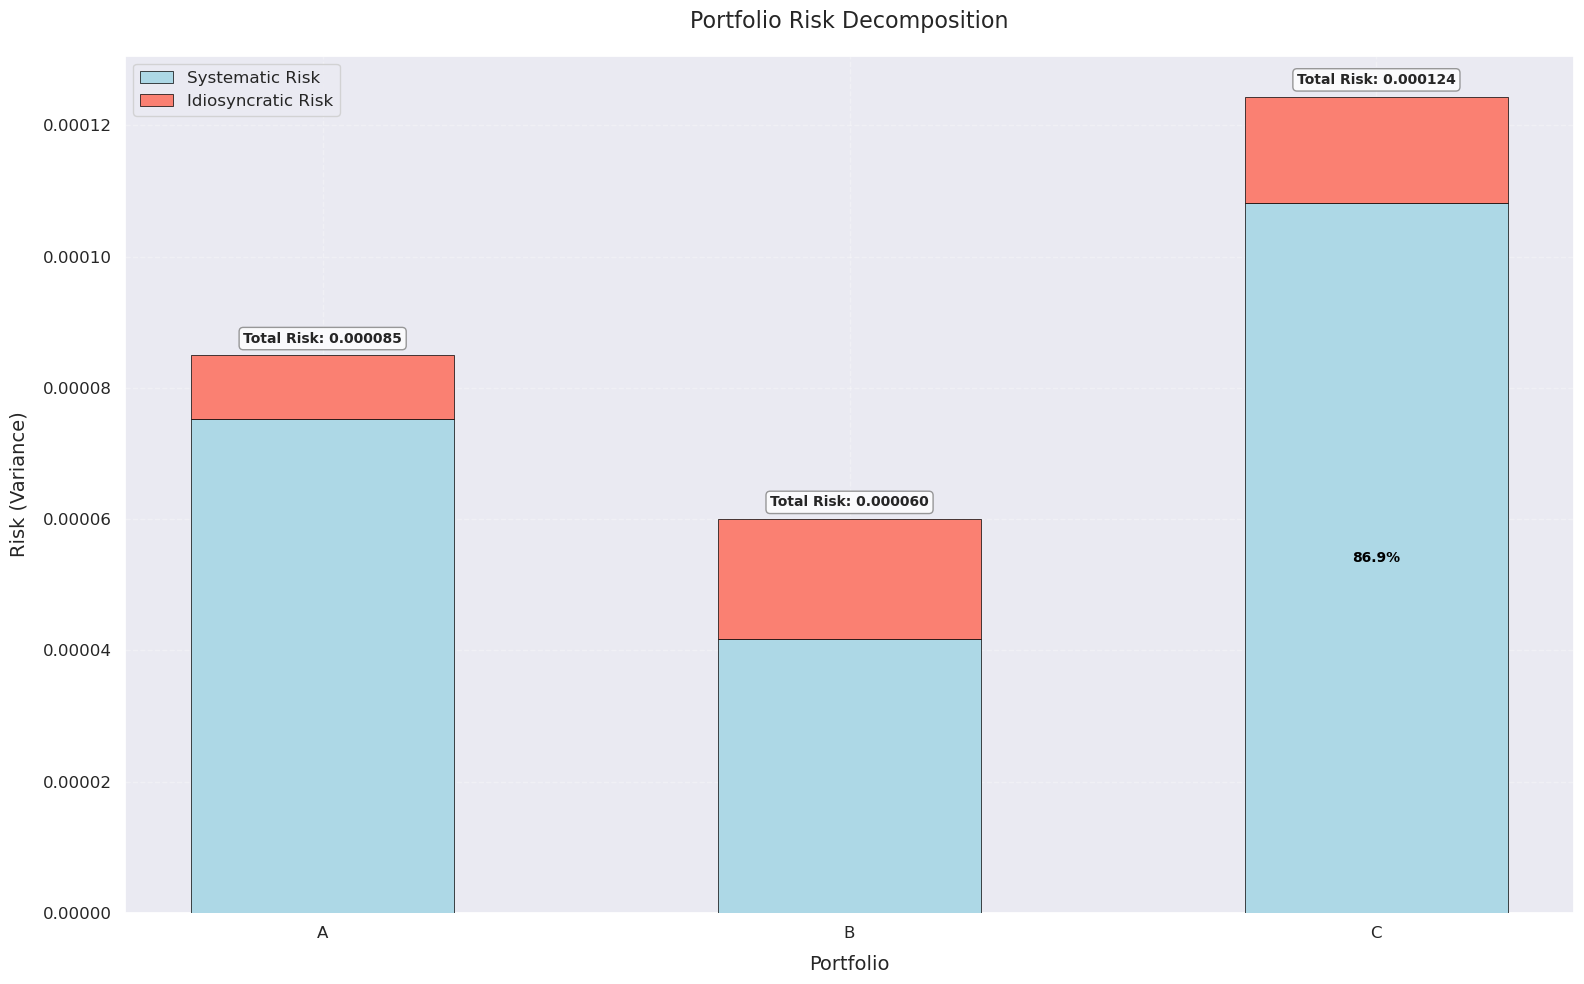

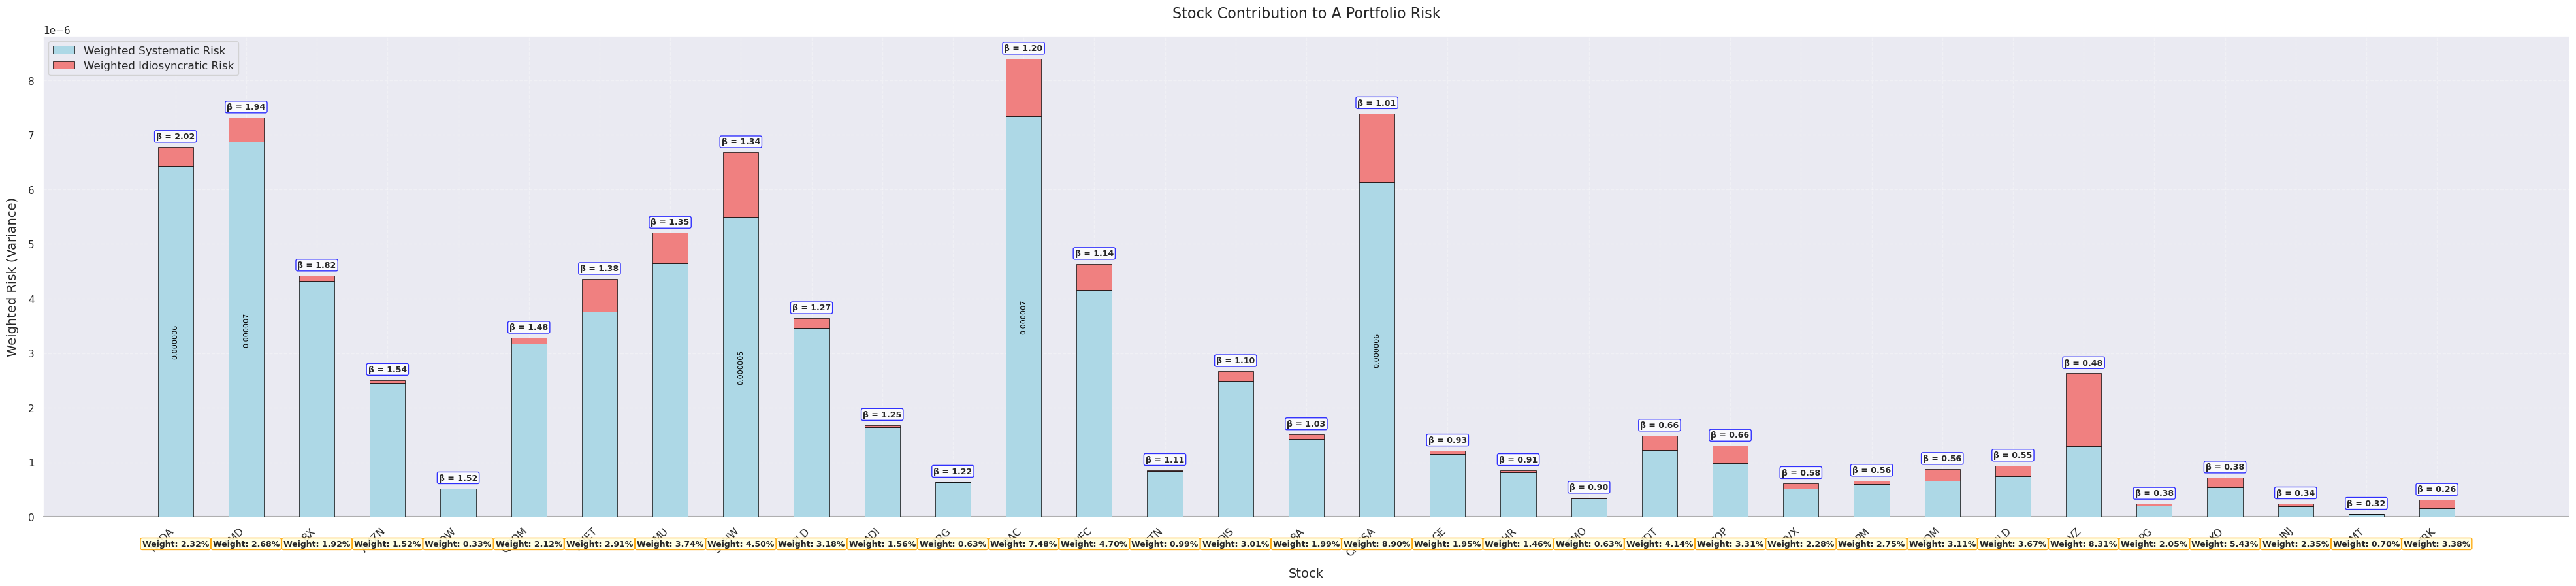

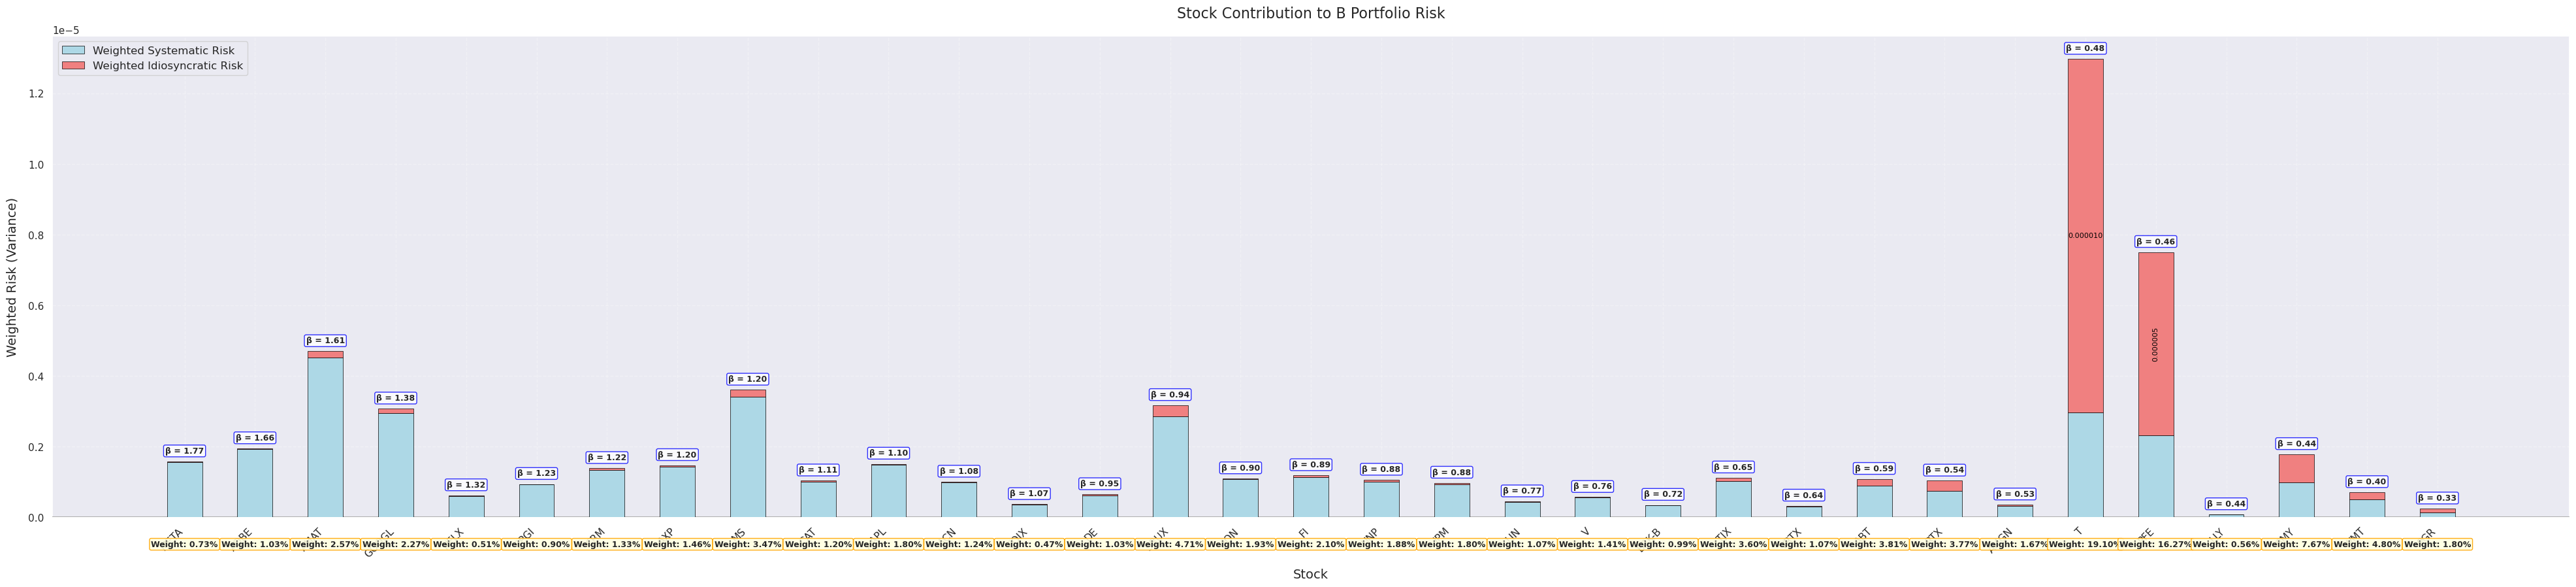

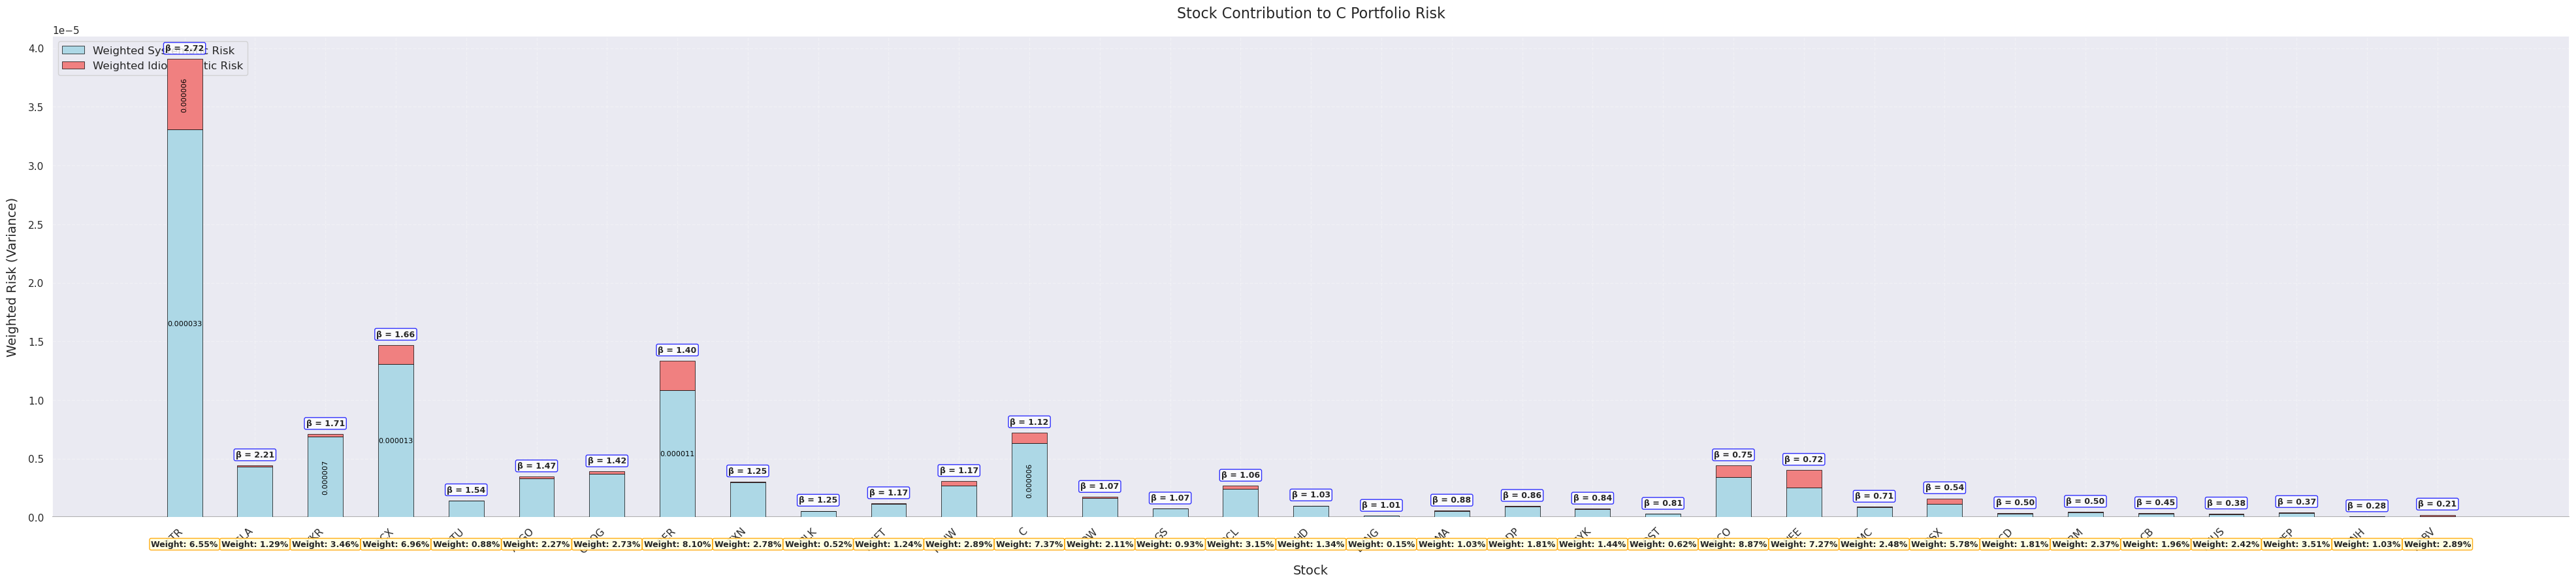


Risk attribution analysis completed, all visualizations saved with improved alignment.


In [ ]:
# Visualization: Plot the proportion of systematic and idiosyncratic returns of portfolios
plt.figure(figsize=(14, 8))

# Set portfolio labels (excluding TOTAL PORTFOLIO)
labels = portfolio_attribution_df['Portfolio'][:-1]  # Exclude the last row (total portfolio)

# Systematic and idiosyncratic return values
systematic_values = portfolio_attribution_df['Systematic_Return'][:-1]
idiosyncratic_values = portfolio_attribution_df['Idiosyncratic_Return'][:-1]
total_values = portfolio_attribution_df['Total_Return'][:-1]

# Create stacked bar chart
width = 0.6
x = np.arange(len(labels))

# Systematic returns (possibly negative)
plt.bar(x, systematic_values, width, label='Systematic Return', color='skyblue')

# Idiosyncratic returns (stacked on systematic returns)
plt.bar(x, idiosyncratic_values, width, bottom=systematic_values, label='Idiosyncratic Return', color='salmon')

plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.title('Systematic and Idiosyncratic Return Decomposition of Portfolios', fontsize=14)
plt.xlabel('Portfolio', fontsize=12)
plt.ylabel('Return', fontsize=12)
plt.xticks(x, labels, fontsize=10)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# Add total return labels
for i, (total, sys_ret, idio_ret) in enumerate(zip(total_values, systematic_values, idiosyncratic_values)):
    # Determine label position
    if idio_ret >= 0:
        label_position = systematic_values[i] + idiosyncratic_values[i] + 0.01
    else:
        # If idiosyncratic return is negative, place label above systematic return
        label_position = max(systematic_values[i], systematic_values[i] + idiosyncratic_values[i]) + 0.01
    
    plt.text(i, label_position, f'Total: {total:.2%}', ha='center', fontsize=9, fontweight='bold')
    
    # Add percentage labels for systematic and idiosyncratic returns
    sys_pct = sys_ret / total if total != 0 else 0
    idio_pct = idio_ret / total if total != 0 else 0
    
    # Only add labels when values are large enough
    if abs(sys_ret) > 0.01:
        plt.text(i, systematic_values[i]/2, f'{sys_pct:.1%}', ha='center', va='center', fontsize=8, color='black')
    
    if abs(idio_ret) > 0.01:
        y_pos = systematic_values[i] + idiosyncratic_values[i]/2
        plt.text(i, y_pos, f'{idio_pct:.1%}', ha='center', va='center', fontsize=8, color='black')

plt.tight_layout()
plt.savefig('portfolio_return_decomposition.png', dpi=300)
plt.show()

# Visualization: Plot portfolio Beta values
plt.figure(figsize=(12, 6))

# Exclude TOTAL PORTFOLIO
x = np.arange(len(labels))
beta_values = portfolio_attribution_df['Beta'][:-1]

plt.bar(x, beta_values, width, label='Portfolio Beta', color='lightgreen')
plt.axhline(y=1, color='red', linestyle='--', label='Market Beta = 1')

plt.title('Systematic Risk (Beta) of Portfolios', fontsize=14)
plt.xlabel('Portfolio', fontsize=12)
plt.ylabel('Beta Value', fontsize=12)
plt.xticks(x, labels, fontsize=10)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# Add beta value labels
for i, beta in enumerate(beta_values):
    plt.text(i, beta + 0.05, f'{beta:.2f}', ha='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('portfolio_beta_values.png', dpi=300)
plt.show()

# Visualization: Scatter plot of idiosyncratic return vs systematic return (stock level)
plt.figure(figsize=(12, 8))

# Draw scatter plot
plt.scatter(
    merged_results['systematic_return'],
    merged_results['idiosyncratic_return'],
    alpha=0.7,
    s=100  # Increase point size
)

# Add reference lines
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)

# Add text labels
for i, row in merged_results.iterrows():
    plt.annotate(
        row['Stock'],
        (row['systematic_return'], row['idiosyncratic_return']),
        fontsize=9,
        xytext=(5, 5),
        textcoords='offset points'
    )

plt.title('Systematic Return vs Idiosyncratic Return of Individual Stocks', fontsize=14)
plt.xlabel('Systematic Return', fontsize=12)
plt.ylabel('Idiosyncratic Return', fontsize=12)
plt.grid(True, alpha=0.3)

# Add color mapping for total return and Beta
plt.colorbar(
    plt.scatter(
        merged_results['systematic_return'],
        merged_results['idiosyncratic_return'],
        c=merged_results['total_return'],
        s=0  # Make this scatter invisible, only used for colorbar
    ),
    label='Total Return'
)

plt.tight_layout()
plt.savefig('stock_return_attribution_scatter.png', dpi=300)
plt.show()

# Calculate detailed stock-level attribution results (each stock within each portfolio)
detailed_attribution = []

for _, portfolio_row in portfolios_normalized.iterrows():
    portfolio_name = portfolio_row['Portfolio']
    stock = portfolio_row['Stock']
    weight = portfolio_row['Weight']
    
    # Get CAPM parameters and attribution results for this stock
    stock_data = merged_results[merged_results['Stock'] == stock]
    
    if not stock_data.empty:
        stock_data = stock_data.iloc[0]
        
        # Calculate this stock's contribution to the portfolio
        weighted_systematic_return = weight * stock_data['systematic_return']
        weighted_idiosyncratic_return = weight * stock_data['idiosyncratic_return']
        weighted_total_return = weight * stock_data['total_return']
        
        # Store results
        detailed_attribution.append({
            'Portfolio': portfolio_name,
            'Stock': stock,
            'Weight': weight,
            'Beta': stock_data['beta'],
            'Alpha': stock_data['alpha'],
            'R_Squared': stock_data['r_squared'],
            'Total_Return': stock_data['total_return'],
            'Systematic_Return': stock_data['systematic_return'],
            'Idiosyncratic_Return': stock_data['idiosyncratic_return'],
            'Weighted_Total_Return': weighted_total_return,
            'Weighted_Systematic_Return': weighted_systematic_return,
            'Weighted_Idiosyncratic_Return': weighted_idiosyncratic_return
        })
    else:
        print(f"Warning: No data for {stock} in portfolio {portfolio_name}")

# Convert to DataFrame
detailed_attribution_df = pd.DataFrame(detailed_attribution)

print("\nDetailed Stock Attribution Results (first few rows):")
print(detailed_attribution_df.head())

# Save detailed results to CSV
detailed_attribution_df.to_csv('detailed_stock_attribution_results.csv', index=False)
print("Detailed stock attribution results saved to 'detailed_stock_attribution_results.csv'")

# Visualization: Stock contributions in each portfolio
for portfolio_name in detailed_attribution_df['Portfolio'].unique():
    # Get stock data for this portfolio
    portfolio_data = detailed_attribution_df[detailed_attribution_df['Portfolio'] == portfolio_name]
    
    # Sort by weighted total return
    portfolio_data = portfolio_data.sort_values('Weighted_Total_Return', ascending=False)
    
    plt.figure(figsize=(14, 8))
    
    # Set stock labels
    labels = portfolio_data['Stock']
    
    # Weighted systematic and idiosyncratic return values
    weighted_systematic = portfolio_data['Weighted_Systematic_Return']
    weighted_idiosyncratic = portfolio_data['Weighted_Idiosyncratic_Return']
    
    # Create stacked bar chart
    width = 0.6
    x = np.arange(len(labels))
    
    plt.bar(x, weighted_systematic, width, label='Weighted Systematic Return', color='skyblue')
    plt.bar(x, weighted_idiosyncratic, width, bottom=weighted_systematic, label='Weighted Idiosyncratic Return', color='salmon')
    
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.title(f'Stock Contribution to {portfolio_name} Portfolio', fontsize=14)
    plt.xlabel('Stock', fontsize=12)
    plt.ylabel('Weighted Return', fontsize=12)
    plt.xticks(x, labels, rotation=45, ha='right', fontsize=9)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # Add total weight labels
    for i, row in enumerate(portfolio_data.itertuples()):
        plt.text(i, row.Weighted_Systematic_Return + row.Weighted_Idiosyncratic_Return + 0.002, 
                f'Weight: {row.Weight:.2%}', ha='center', fontsize=8, rotation=45)
    
    plt.tight_layout()
    plt.savefig(f'{portfolio_name}_stock_contributions.png', dpi=300)
    plt.show()

print("\nAnalysis completed and visualizations saved.")

# PART 2

In [54]:
# ### 1. 计算预期收益率和无风险利率

# 计算回归期间 SPY 的平均收益率作为市场预期收益率
market_expected_return = regression_period['SPY'].mean()
print(f"Expected Market Return (SPY): {market_expected_return:.6f}")

# 计算回归期间的平均无风险利率
rf_expected = aligned_rf['rf'].mean()
print(f"Expected Risk-Free Rate: {rf_expected:.6f}")

# 计算回归期间的市场风险溢价
market_risk_premium = market_expected_return - rf_expected
print(f"Market Risk Premium: {market_risk_premium:.6f}")

# ### 2. 计算每只股票的预期收益率 (假设 alpha = 0)

# 创建一个 DataFrame 来存储期望收益率和风险
expected_returns_df = pd.DataFrame(index=capm_df['Stock'])
expected_returns_df['beta'] = capm_df.set_index('Stock')['beta']

# 使用 CAPM 计算预期收益率 (E[r] = rf + beta * (E[rm] - rf))
# 假设 alpha = 0 (根据题目要求)
expected_returns_df['expected_return'] = rf_expected + expected_returns_df['beta'] * market_risk_premium
print("\nExpected Returns (First 5 stocks):")
print(expected_returns_df.head())

# ### 3. 为每个投资组合创建协方差矩阵

# 获取投资组合列表
portfolios_list = portfolios['Portfolio'].unique()

# 为每个投资组合计算协方差矩阵
portfolio_cov_matrices = {}

for portfolio_name in portfolios_list:
    # 获取投资组合中的股票
    portfolio_stocks = portfolios[portfolios['Portfolio'] == portfolio_name]['Stock'].unique()
    
    # 检查所有股票是否在回归期数据中
    valid_stocks = [stock for stock in portfolio_stocks if stock in regression_period.columns]
    
    if len(valid_stocks) > 0:
        # 提取该投资组合股票的收益率数据
        portfolio_returns = regression_period[valid_stocks]
        
        # 计算协方差矩阵
        cov_matrix = portfolio_returns.cov()
        portfolio_cov_matrices[portfolio_name] = cov_matrix
    else:
        print(f"Warning: No valid stocks found for portfolio {portfolio_name}")

# 输出第一个投资组合的协方差矩阵预览
first_portfolio = portfolios_list[0]
print(f"\nCovariance Matrix for {first_portfolio} (Preview):")
print(portfolio_cov_matrices[first_portfolio].iloc[:5, :5])

Expected Market Return (SPY): 0.000985
Expected Risk-Free Rate: 0.000002
Market Risk Premium: 0.000983

Expected Returns (First 5 stocks):
           beta  expected_return
Stock                           
WFC    1.140088         0.001123
ETN    1.113597         0.001097
AMZN   1.537007         0.001513
QCOM   1.483601         0.001460
LMT    0.317445         0.000314

Covariance Matrix for A (Preview):
           WFC       ETN      AMZN      QCOM       LMT
WFC   0.000305  0.000098  0.000050  0.000123  0.000042
ETN   0.000098  0.000278  0.000081  0.000114  0.000032
AMZN  0.000050  0.000081  0.000433  0.000162 -0.000003
QCOM  0.000123  0.000114  0.000162  0.000391  0.000011
LMT   0.000042  0.000032 -0.000003  0.000011  0.000130


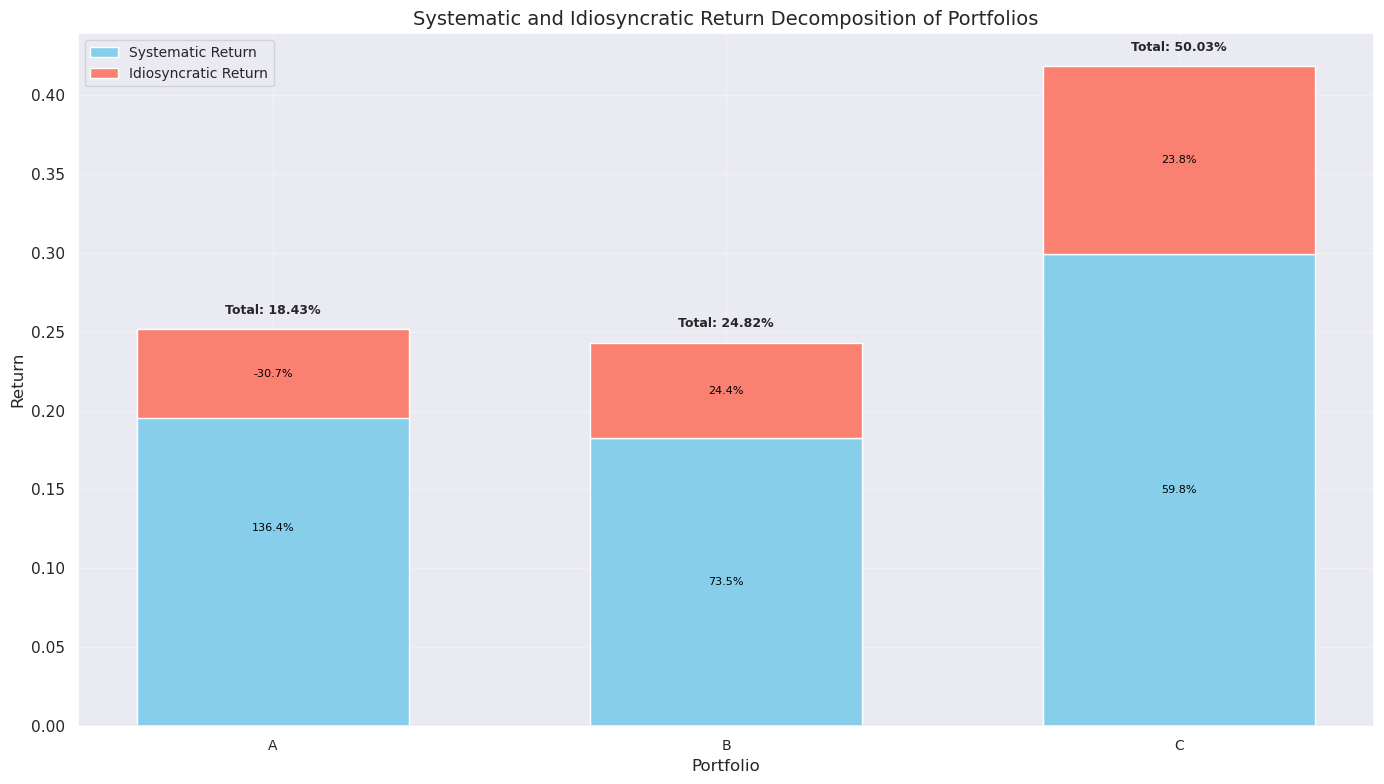

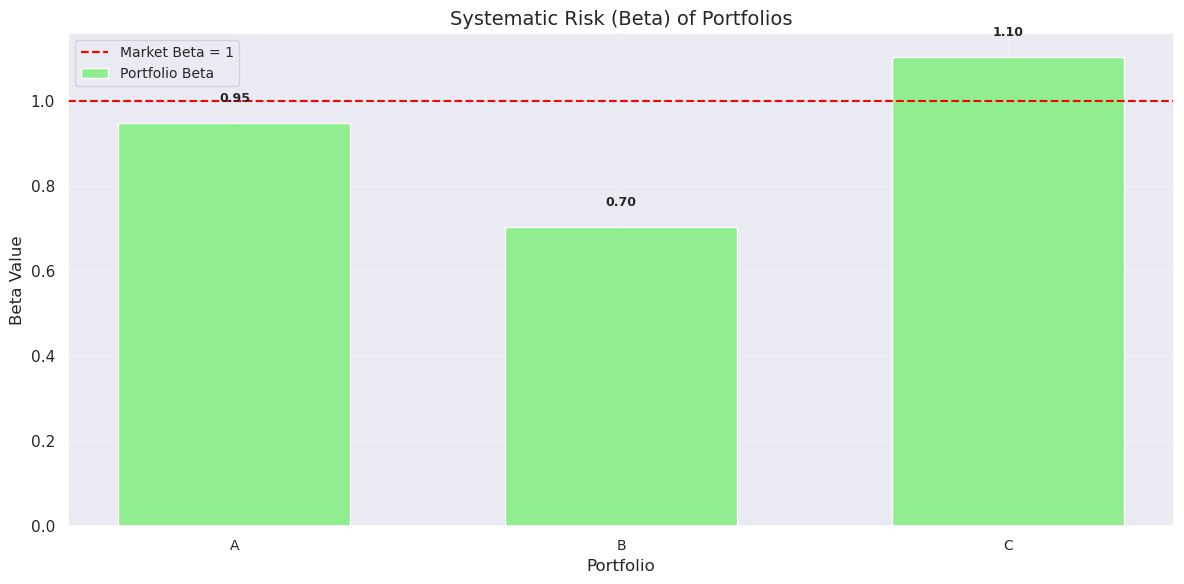

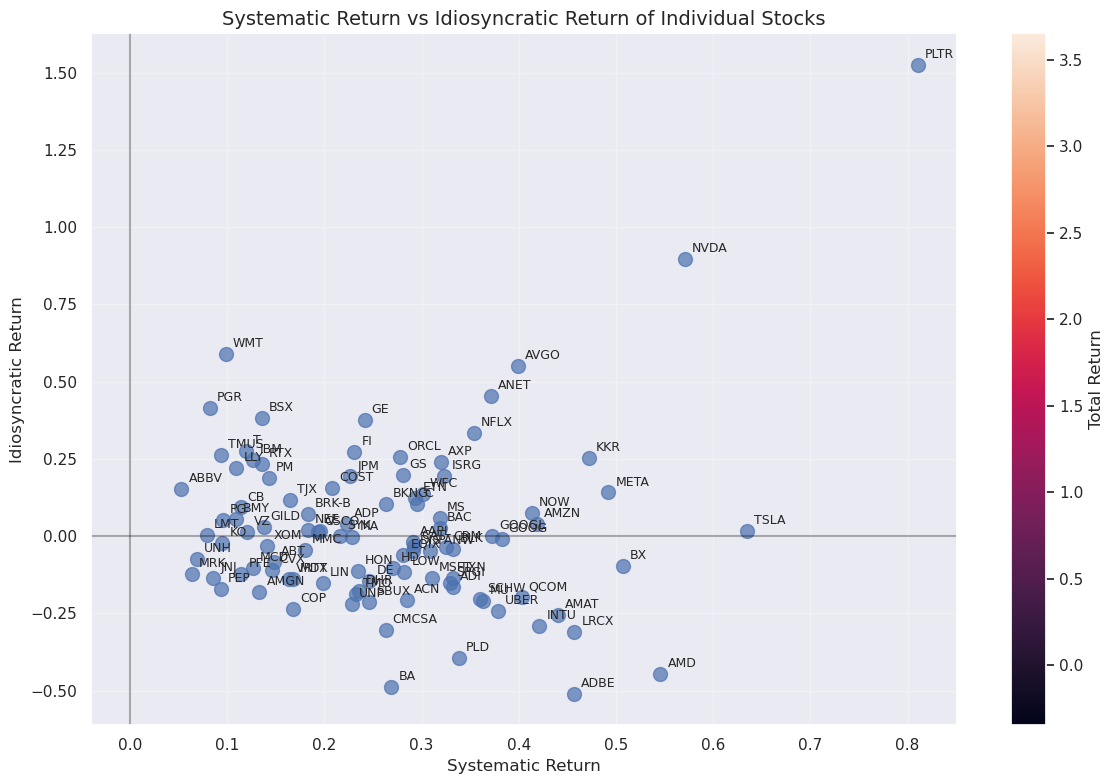


Detailed Stock Attribution Results (first few rows):
  Portfolio Stock    Weight      Beta     Alpha  R_Squared  Total_Return  \
0         A   WFC  0.047004  1.140088 -0.000189   0.289900      0.487094   
1         A   ETN  0.009930  1.113597  0.000815   0.303543      0.440136   
2         A  AMZN  0.015227  1.537007  0.000999   0.371209      0.475517   
3         A  QCOM  0.021185  1.483601  0.000044   0.382640      0.112787   
4         A   LMT  0.006951  0.317445 -0.000352   0.052900      0.084088   

   Systematic_Return  Idiosyncratic_Return  Weighted_Total_Return  \
0           0.301307              0.136159               0.022896   
1           0.293691              0.123467               0.004371   
2           0.419004              0.040192               0.007241   
3           0.402776             -0.197798               0.002389   
4           0.078753              0.003356               0.000585   

   Weighted_Systematic_Return  Weighted_Idiosyncratic_Return  
0          

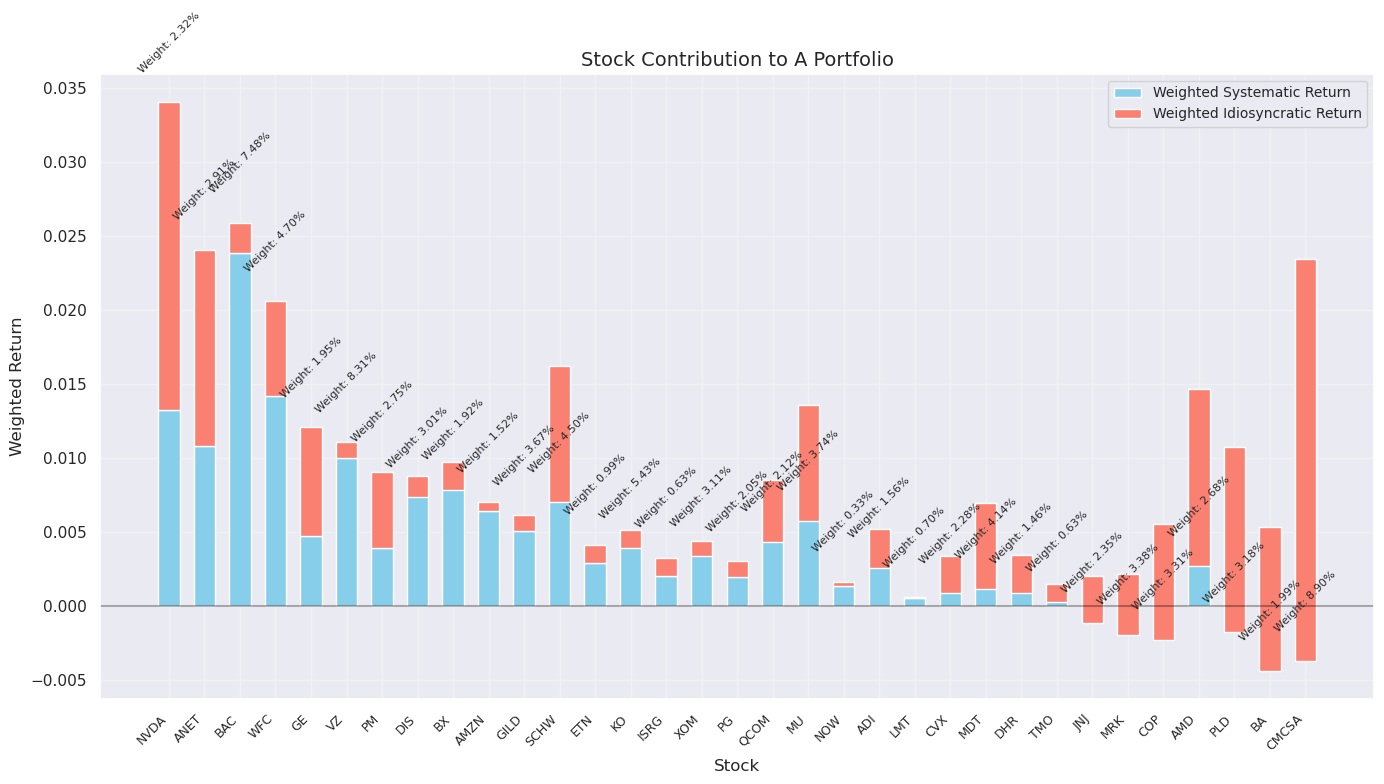

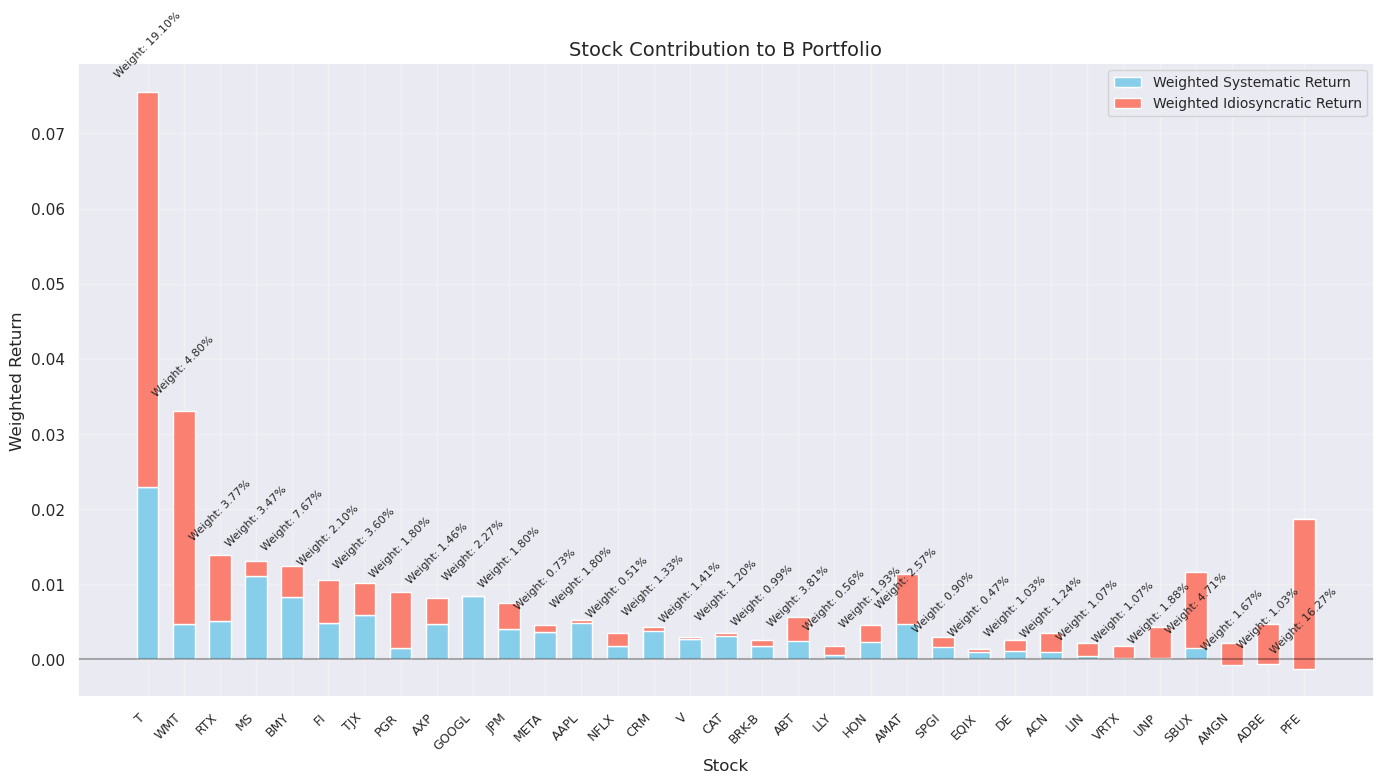

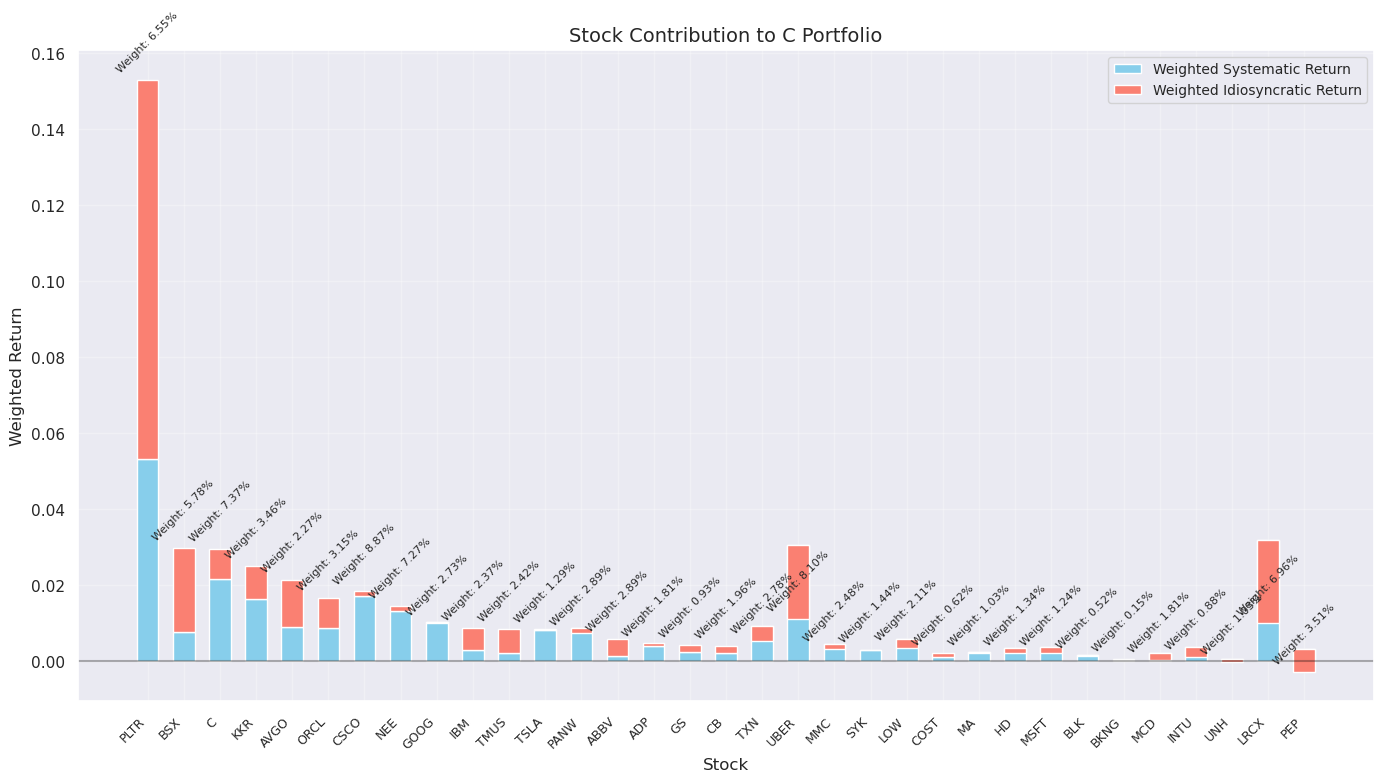


Analysis completed and visualizations saved.


In [13]:
# Visualization: Plot the proportion of systematic and idiosyncratic returns of portfolios
plt.figure(figsize=(14, 8))

# Set portfolio labels (excluding TOTAL PORTFOLIO)
labels = portfolio_attribution_df['Portfolio'][:-1]  # Exclude the last row (total portfolio)

# Systematic and idiosyncratic return values
systematic_values = portfolio_attribution_df['Systematic_Return'][:-1]
idiosyncratic_values = portfolio_attribution_df['Idiosyncratic_Return'][:-1]
total_values = portfolio_attribution_df['Total_Return'][:-1]

# Create stacked bar chart
width = 0.6
x = np.arange(len(labels))

# Systematic returns (possibly negative)
plt.bar(x, systematic_values, width, label='Systematic Return', color='skyblue')

# Idiosyncratic returns (stacked on systematic returns)
plt.bar(x, idiosyncratic_values, width, bottom=systematic_values, label='Idiosyncratic Return', color='salmon')

plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.title('Systematic and Idiosyncratic Return Decomposition of Portfolios', fontsize=14)
plt.xlabel('Portfolio', fontsize=12)
plt.ylabel('Return', fontsize=12)
plt.xticks(x, labels, fontsize=10)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# Add total return labels
for i, (total, sys_ret, idio_ret) in enumerate(zip(total_values, systematic_values, idiosyncratic_values)):
    # Determine label position
    if idio_ret >= 0:
        label_position = systematic_values[i] + idiosyncratic_values[i] + 0.01
    else:
        # If idiosyncratic return is negative, place label above systematic return
        label_position = max(systematic_values[i], systematic_values[i] + idiosyncratic_values[i]) + 0.01
    
    plt.text(i, label_position, f'Total: {total:.2%}', ha='center', fontsize=9, fontweight='bold')
    
    # Add percentage labels for systematic and idiosyncratic returns
    sys_pct = sys_ret / total if total != 0 else 0
    idio_pct = idio_ret / total if total != 0 else 0
    
    # Only add labels when values are large enough
    if abs(sys_ret) > 0.01:
        plt.text(i, systematic_values[i]/2, f'{sys_pct:.1%}', ha='center', va='center', fontsize=8, color='black')
    
    if abs(idio_ret) > 0.01:
        y_pos = systematic_values[i] + idiosyncratic_values[i]/2
        plt.text(i, y_pos, f'{idio_pct:.1%}', ha='center', va='center', fontsize=8, color='black')

plt.tight_layout()
plt.savefig('portfolio_return_decomposition.png', dpi=300)
plt.show()

# Visualization: Plot portfolio Beta values
plt.figure(figsize=(12, 6))

# Exclude TOTAL PORTFOLIO
x = np.arange(len(labels))
beta_values = portfolio_attribution_df['Beta'][:-1]

plt.bar(x, beta_values, width, label='Portfolio Beta', color='lightgreen')
plt.axhline(y=1, color='red', linestyle='--', label='Market Beta = 1')

plt.title('Systematic Risk (Beta) of Portfolios', fontsize=14)
plt.xlabel('Portfolio', fontsize=12)
plt.ylabel('Beta Value', fontsize=12)
plt.xticks(x, labels, fontsize=10)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# Add beta value labels
for i, beta in enumerate(beta_values):
    plt.text(i, beta + 0.05, f'{beta:.2f}', ha='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('portfolio_beta_values.png', dpi=300)
plt.show()

# Visualization: Scatter plot of idiosyncratic return vs systematic return (stock level)
plt.figure(figsize=(12, 8))

# Draw scatter plot
plt.scatter(
    merged_results['systematic_return'],
    merged_results['idiosyncratic_return'],
    alpha=0.7,
    s=100  # Increase point size
)

# Add reference lines
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)

# Add text labels
for i, row in merged_results.iterrows():
    plt.annotate(
        row['Stock'],
        (row['systematic_return'], row['idiosyncratic_return']),
        fontsize=9,
        xytext=(5, 5),
        textcoords='offset points'
    )

plt.title('Systematic Return vs Idiosyncratic Return of Individual Stocks', fontsize=14)
plt.xlabel('Systematic Return', fontsize=12)
plt.ylabel('Idiosyncratic Return', fontsize=12)
plt.grid(True, alpha=0.3)

# Add color mapping for total return and Beta
plt.colorbar(
    plt.scatter(
        merged_results['systematic_return'],
        merged_results['idiosyncratic_return'],
        c=merged_results['total_return'],
        s=0  # Make this scatter invisible, only used for colorbar
    ),
    label='Total Return'
)

plt.tight_layout()
plt.savefig('stock_return_attribution_scatter.png', dpi=300)
plt.show()

# Calculate detailed stock-level attribution results (each stock within each portfolio)
detailed_attribution = []

for _, portfolio_row in portfolios_normalized.iterrows():
    portfolio_name = portfolio_row['Portfolio']
    stock = portfolio_row['Stock']
    weight = portfolio_row['Weight']
    
    # Get CAPM parameters and attribution results for this stock
    stock_data = merged_results[merged_results['Stock'] == stock]
    
    if not stock_data.empty:
        stock_data = stock_data.iloc[0]
        
        # Calculate this stock's contribution to the portfolio
        weighted_systematic_return = weight * stock_data['systematic_return']
        weighted_idiosyncratic_return = weight * stock_data['idiosyncratic_return']
        weighted_total_return = weight * stock_data['total_return']
        
        # Store results
        detailed_attribution.append({
            'Portfolio': portfolio_name,
            'Stock': stock,
            'Weight': weight,
            'Beta': stock_data['beta'],
            'Alpha': stock_data['alpha'],
            'R_Squared': stock_data['r_squared'],
            'Total_Return': stock_data['total_return'],
            'Systematic_Return': stock_data['systematic_return'],
            'Idiosyncratic_Return': stock_data['idiosyncratic_return'],
            'Weighted_Total_Return': weighted_total_return,
            'Weighted_Systematic_Return': weighted_systematic_return,
            'Weighted_Idiosyncratic_Return': weighted_idiosyncratic_return
        })
    else:
        print(f"Warning: No data for {stock} in portfolio {portfolio_name}")

# Convert to DataFrame
detailed_attribution_df = pd.DataFrame(detailed_attribution)

print("\nDetailed Stock Attribution Results (first few rows):")
print(detailed_attribution_df.head())

# Save detailed results to CSV
detailed_attribution_df.to_csv('detailed_stock_attribution_results.csv', index=False)
print("Detailed stock attribution results saved to 'detailed_stock_attribution_results.csv'")

# Visualization: Stock contributions in each portfolio
for portfolio_name in detailed_attribution_df['Portfolio'].unique():
    # Get stock data for this portfolio
    portfolio_data = detailed_attribution_df[detailed_attribution_df['Portfolio'] == portfolio_name]
    
    # Sort by weighted total return
    portfolio_data = portfolio_data.sort_values('Weighted_Total_Return', ascending=False)
    
    plt.figure(figsize=(14, 8))
    
    # Set stock labels
    labels = portfolio_data['Stock']
    
    # Weighted systematic and idiosyncratic return values
    weighted_systematic = portfolio_data['Weighted_Systematic_Return']
    weighted_idiosyncratic = portfolio_data['Weighted_Idiosyncratic_Return']
    
    # Create stacked bar chart
    width = 0.6
    x = np.arange(len(labels))
    
    plt.bar(x, weighted_systematic, width, label='Weighted Systematic Return', color='skyblue')
    plt.bar(x, weighted_idiosyncratic, width, bottom=weighted_systematic, label='Weighted Idiosyncratic Return', color='salmon')
    
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.title(f'Stock Contribution to {portfolio_name} Portfolio', fontsize=14)
    plt.xlabel('Stock', fontsize=12)
    plt.ylabel('Weighted Return', fontsize=12)
    plt.xticks(x, labels, rotation=45, ha='right', fontsize=9)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # Add total weight labels
    for i, row in enumerate(portfolio_data.itertuples()):
        plt.text(i, row.Weighted_Systematic_Return + row.Weighted_Idiosyncratic_Return + 0.002, 
                f'Weight: {row.Weight:.2%}', ha='center', fontsize=8, rotation=45)
    
    plt.tight_layout()
    plt.savefig(f'{portfolio_name}_stock_contributions.png', dpi=300)
    plt.show()

print("\nAnalysis completed and visualizations saved.")

In [11]:
# ### 8. 计算优化投资组合的系统性和非系统性回报归因

# 将无风险利率与持仓期对齐
holding_rf = rf.reindex(holding_period.index)

# 计算优化投资组合的回报归因
optimal_portfolio_attribution = []

for portfolio_name in optimal_portfolios.keys():
    # 获取投资组合的股票和权重
    portfolio_data = optimal_weights_df[optimal_weights_df['Portfolio'] == portfolio_name]
    
    # 初始化投资组合的回报值
    portfolio_systematic = 0
    portfolio_idiosyncratic = 0
    portfolio_total = 0
    portfolio_beta = 0
    covered_weight = 0
    
    # 计算加权回报
    for _, row in portfolio_data.iterrows():
        stock = row['Stock']
        weight = row['Weight']
        
        if stock in merged_results['Stock'].values:
            # 获取该股票的回报归因
            stock_data = merged_results[merged_results['Stock'] == stock].iloc[0]
            
            # 累加加权回报
            portfolio_systematic += weight * stock_data['systematic_return']
            portfolio_idiosyncratic += weight * stock_data['idiosyncratic_return']
            portfolio_total += weight * stock_data['total_return']
            portfolio_beta += weight * stock_data['beta']
            covered_weight += weight
        else:
            print(f"Warning: {stock} does not exist in return attribution data")
    
    # 如果有缺失的股票，重新调整权重
    if covered_weight < 1.0 and covered_weight > 0:
        adjustment_factor = 1.0 / covered_weight
        portfolio_systematic *= adjustment_factor
        portfolio_idiosyncratic *= adjustment_factor
        portfolio_total *= adjustment_factor
        portfolio_beta *= adjustment_factor
        
    # 添加到结果列表
    optimal_portfolio_attribution.append({
        'Portfolio': portfolio_name,
        'Beta': portfolio_beta,
        'Total_Return': portfolio_total,
        'Systematic_Return': portfolio_systematic,
        'Idiosyncratic_Return': portfolio_idiosyncratic,
        'Systematic_Proportion': portfolio_systematic / portfolio_total if portfolio_total != 0 else 0,
        'Idiosyncratic_Proportion': portfolio_idiosyncratic / portfolio_total if portfolio_total != 0 else 0,
        'Covered_Weight': covered_weight
    })

# 转换为DataFrame
optimal_portfolio_attribution_df = pd.DataFrame(optimal_portfolio_attribution)
optimal_portfolio_attribution_df.to_csv('PART_2_optimal_portfolio_attribution.csv', index=False)
print("\nOptimal Portfolio Return Attribution Results:")
print(optimal_portfolio_attribution_df)

NameError: name 'optimal_portfolios' is not defined

In [57]:
# ### 9. 计算优化投资组合的系统性和非系统性风险归因

# 计算市场收益率的方差（使用回归期间的数据）
market_variance = regression_period['SPY'].var()

# 计算优化投资组合的风险归因
optimal_portfolio_risk_attribution = []

for portfolio_name in optimal_portfolios.keys():
    # 获取投资组合的股票和权重
    portfolio_data = optimal_weights_df[optimal_weights_df['Portfolio'] == portfolio_name]
    
    # 与merged_results连接，获取每只股票的风险归因数据
    portfolio_risk_data = pd.merge(
        portfolio_data,
        merged_results[['Stock', 'beta', 'systematic_risk', 'idiosyncratic_risk', 'total_risk']],
        on='Stock',
        how='inner'
    )
    
    # 如果有股票缺失数据，打印警告
    missing_stocks = set(portfolio_data['Stock']) - set(portfolio_risk_data['Stock'])
    if missing_stocks:
        print(f"Warning: {missing_stocks} in optimal portfolio {portfolio_name} are missing from risk attribution data")
    
    # 计算投资组合级别的风险指标
    if not portfolio_risk_data.empty:
        # 1. 系统性风险 - 简单加权平均
        portfolio_systematic_risk = (portfolio_risk_data['systematic_risk'] * portfolio_risk_data['Weight']).sum()
        
        # 2. 非系统性风险 - 使用权重平方加权
        portfolio_idiosyncratic_risk = (portfolio_risk_data['idiosyncratic_risk'] * (portfolio_risk_data['Weight'] ** 2)).sum()
        
        # 3. 计算总风险
        portfolio_total_risk = portfolio_systematic_risk + portfolio_idiosyncratic_risk
        
        # 4. 计算风险占比
        systematic_risk_proportion = portfolio_systematic_risk / portfolio_total_risk if portfolio_total_risk != 0 else 0
        idiosyncratic_risk_proportion = portfolio_idiosyncratic_risk / portfolio_total_risk if portfolio_total_risk != 0 else 0
        
        # 5. 投资组合的贝塔值 - 使用权重加权
        portfolio_beta = (portfolio_risk_data['beta'] * portfolio_risk_data['Weight']).sum()
        
        # 存储结果
        optimal_portfolio_risk_attribution.append({
            'Portfolio': portfolio_name,
            'Beta': portfolio_beta,
            'Total_Risk': portfolio_total_risk,
            'Systematic_Risk': portfolio_systematic_risk,
            'Idiosyncratic_Risk': portfolio_idiosyncratic_risk,
            'Systematic_Risk_Proportion': systematic_risk_proportion,
            'Idiosyncratic_Risk_Proportion': idiosyncratic_risk_proportion
        })
    else:
        print(f"Warning: Optimal portfolio {portfolio_name} has no valid risk data")

# 转换为DataFrame
optimal_portfolio_risk_df = pd.DataFrame(optimal_portfolio_risk_attribution)
optimal_portfolio_risk_df.to_csv('PART_2_optimal_portfolio_risk.csv', index=False)
print("\nOptimal Portfolio Risk Attribution Results:")
print(optimal_portfolio_risk_df)


Optimal Portfolio Risk Attribution Results:
  Portfolio      Beta  Total_Risk  Systematic_Risk  Idiosyncratic_Risk  \
0         A  1.013348    0.000098         0.000088            0.000009   
1         B  1.010687    0.000085         0.000079            0.000006   
2         C  1.018714    0.000092         0.000084            0.000008   

   Systematic_Risk_Proportion  Idiosyncratic_Risk_Proportion  
0                    0.902883                       0.097117  
1                    0.923910                       0.076090  
2                    0.914488                       0.085512  



Portfolio Performance Comparison:
  Portfolio  Original_Total_Return  Original_Systematic_Return  \
0         A               0.184326                    0.251480   
1         B               0.248237                    0.182378   
2         C               0.500267                    0.298922   

   Original_Idiosyncratic_Return  Original_Total_Risk  \
0                      -0.056499             0.000085   
1                       0.060642             0.000060   
2                       0.119171             0.000124   

   Original_Systematic_Risk  Original_Idiosyncratic_Risk  Original_Beta  \
0                  0.000075                     0.000010       0.949232   
1                  0.000042                     0.000018       0.704469   
2                  0.000108                     0.000016       1.104456   

   Optimal_Total_Return  Optimal_Systematic_Return  \
0              0.287216                   0.270892   
1              0.256790                   0.267270   
2       

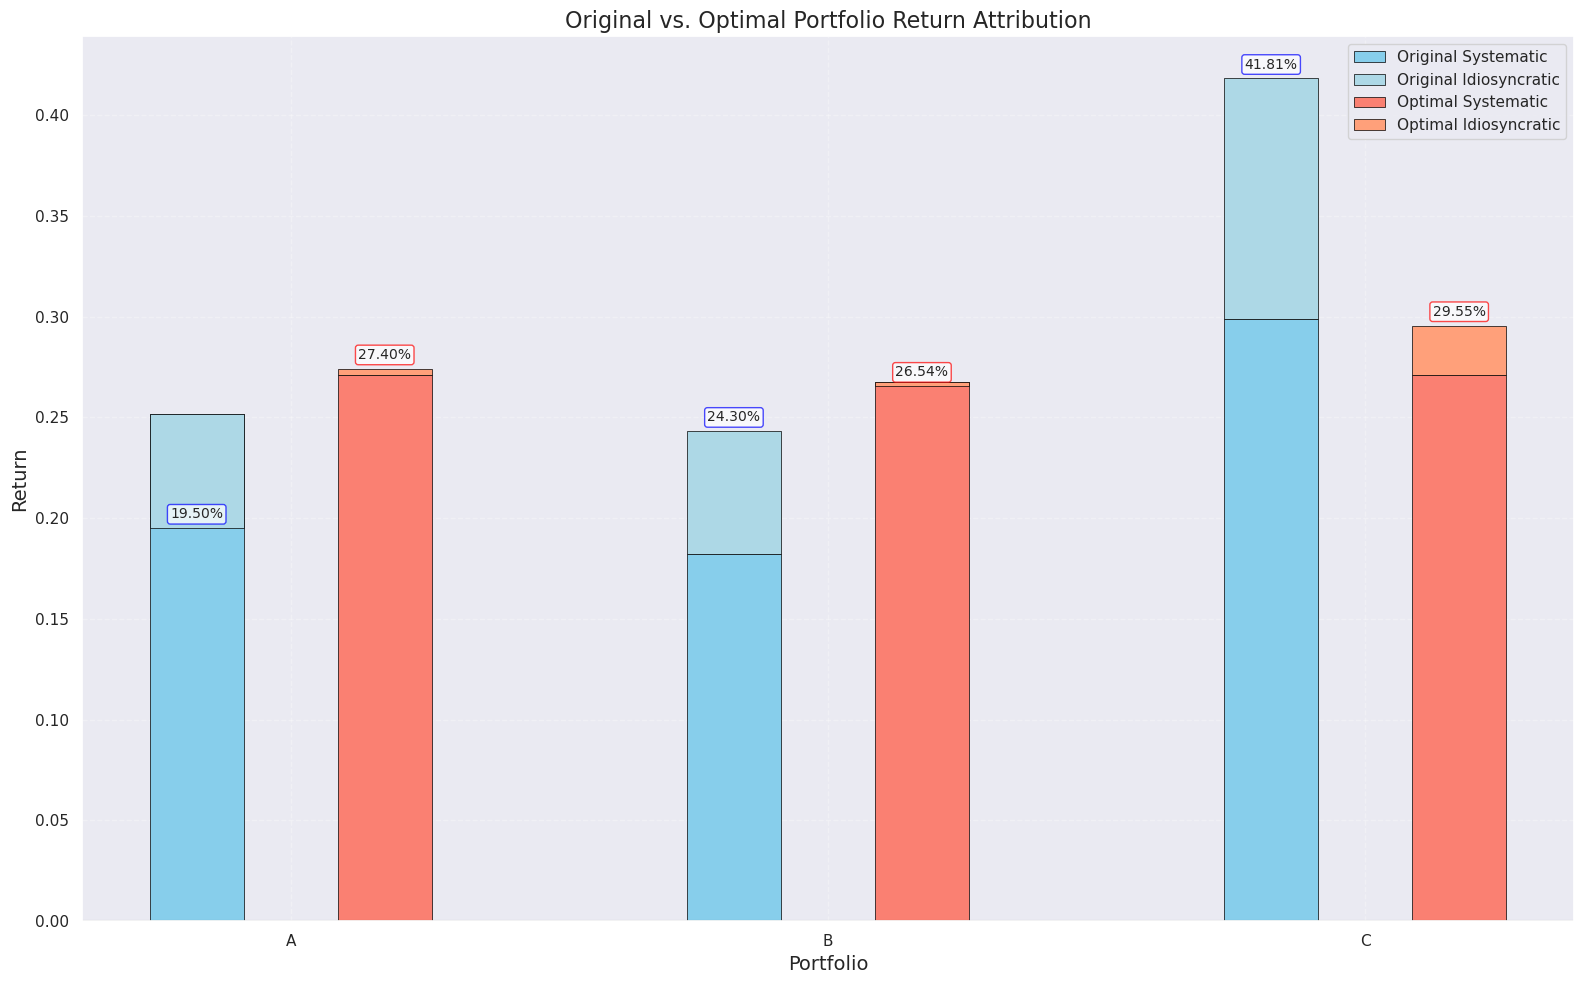

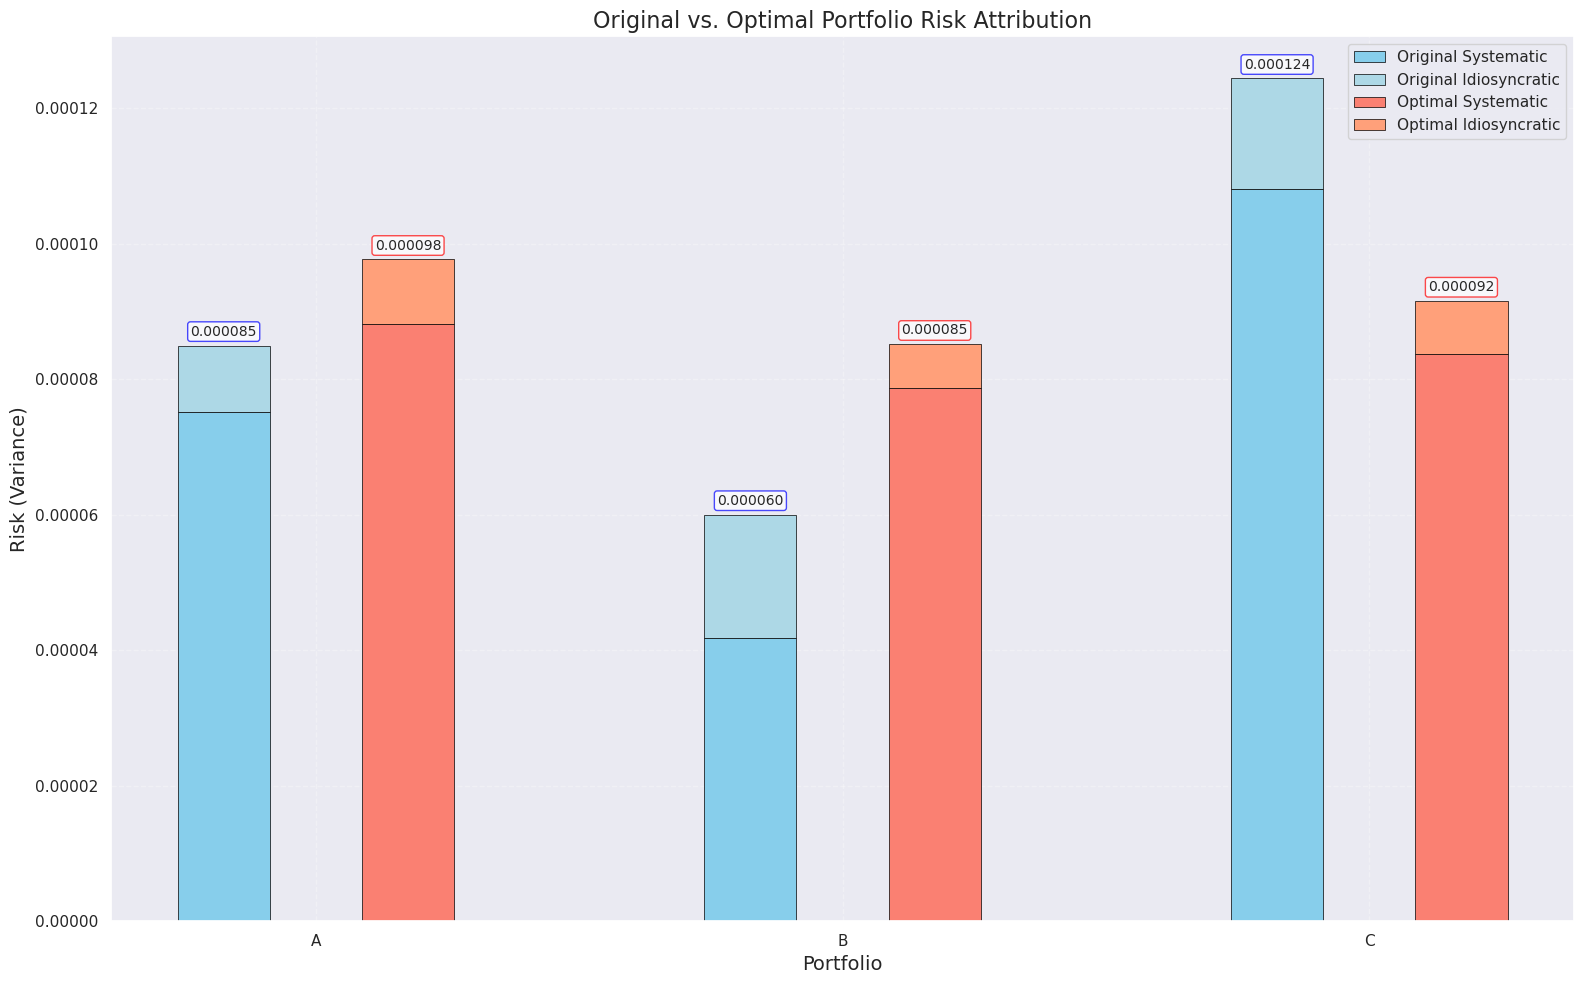

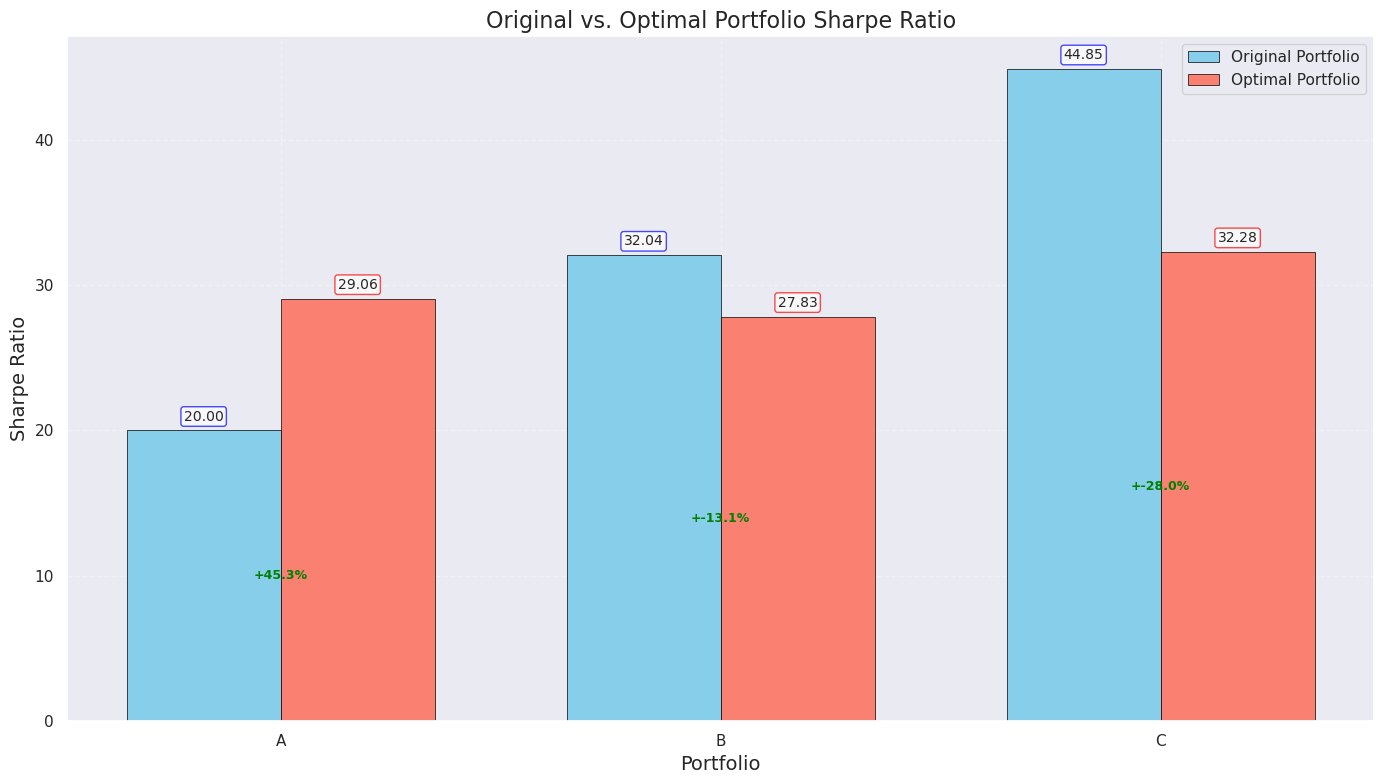

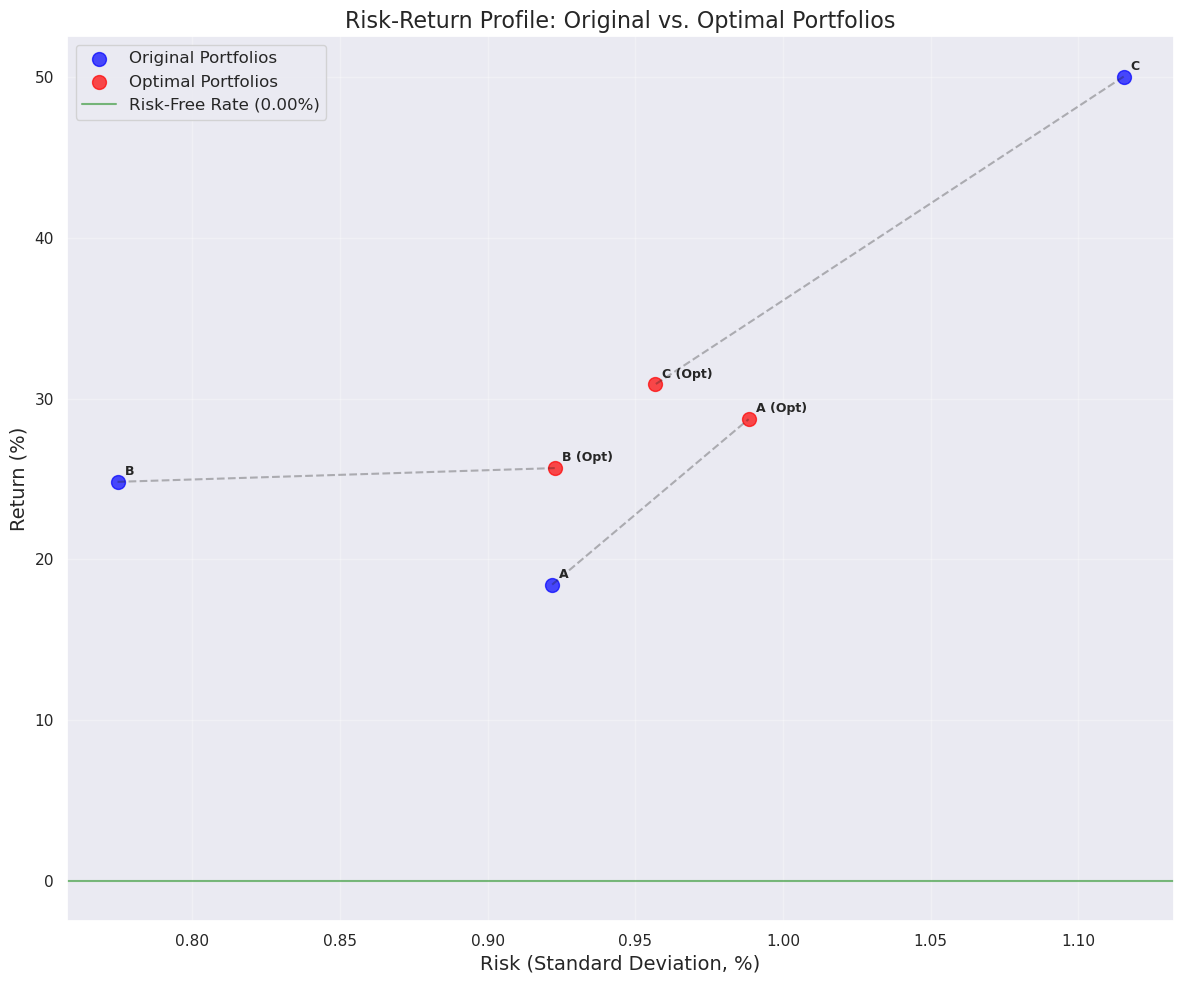

Optimal portfolio weights saved to 'optimal_portfolio_weights.csv'
Optimal portfolio return attribution saved to 'optimal_portfolio_return_attribution.csv'
Optimal portfolio risk attribution saved to 'optimal_portfolio_risk_attribution.csv'
Portfolio comparison results saved to 'portfolio_comparison.csv'

Summary of Improvements:
Average Return Improvement: 7.00%
Average Risk Reduction: -10.13%
Average Sharpe Ratio Improvement: 1.38%

Risk Component Analysis:
Original Portfolios - Average Systematic Risk Proportion: 83.57%
Optimal Portfolios - Average Systematic Risk Proportion: 91.33%
Change in Systematic Risk Proportion: 7.76 percentage points

Portfolio-Specific Analysis:
Portfolio with Highest Sharpe Ratio Improvement: A (+45.33%)
Portfolio with Lowest Sharpe Ratio Improvement: C (+-28.04%)

Portfolio Concentration Analysis (Herfindahl Index):
  Portfolio  Original_HI  Optimal_HI  Change_Pct
0         A     0.044064    0.046029    4.457434
1         B     0.083964    0.045900  -45.

/tmp/ipykernel_6778/2157142637.py:369: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  concentration_comparison = concentration_comparison._append({


In [51]:
# ### 10. 比较原始投资组合和优化投资组合的性能

# 创建完整的比较表
comparison_df = pd.DataFrame()

# 原始投资组合回报
original_returns = portfolio_attribution_df[portfolio_attribution_df['Portfolio'] != 'TOTAL PORTFOLIO'].copy()
original_returns = original_returns[['Portfolio', 'Total_Return', 'Systematic_Return', 'Idiosyncratic_Return']]
original_returns.columns = ['Portfolio', 'Original_Total_Return', 'Original_Systematic_Return', 'Original_Idiosyncratic_Return']

# 原始投资组合风险
original_risks = portfolio_risk_df[portfolio_risk_df['Portfolio'] != 'TOTAL PORTFOLIO'].copy()
original_risks = original_risks[['Portfolio', 'Total_Risk', 'Systematic_Risk', 'Idiosyncratic_Risk', 'Beta']]
original_risks.columns = ['Portfolio', 'Original_Total_Risk', 'Original_Systematic_Risk', 'Original_Idiosyncratic_Risk', 'Original_Beta']

# 合并原始数据
comparison_df = pd.merge(original_returns, original_risks, on='Portfolio', how='outer')

# 优化投资组合回报
optimal_returns = optimal_portfolio_attribution_df.copy()
optimal_returns = optimal_returns[['Portfolio', 'Total_Return', 'Systematic_Return', 'Idiosyncratic_Return']]
optimal_returns.columns = ['Portfolio', 'Optimal_Total_Return', 'Optimal_Systematic_Return', 'Optimal_Idiosyncratic_Return']

# 优化投资组合风险
optimal_risks = optimal_portfolio_risk_df.copy()
optimal_risks = optimal_risks[['Portfolio', 'Total_Risk', 'Systematic_Risk', 'Idiosyncratic_Risk', 'Beta']]
optimal_risks.columns = ['Portfolio', 'Optimal_Total_Risk', 'Optimal_Systematic_Risk', 'Optimal_Idiosyncratic_Risk', 'Optimal_Beta']

# 合并优化数据
comparison_df = pd.merge(comparison_df, optimal_returns, on='Portfolio', how='outer')
comparison_df = pd.merge(comparison_df, optimal_risks, on='Portfolio', how='outer')

# 计算原始投资组合的夏普比率
comparison_df['Original_Sharpe'] = (comparison_df['Original_Total_Return'] - rf_expected) / np.sqrt(comparison_df['Original_Total_Risk'])

# 计算优化投资组合的夏普比率
comparison_df['Optimal_Sharpe'] = (comparison_df['Optimal_Total_Return'] - rf_expected) / np.sqrt(comparison_df['Optimal_Total_Risk'])

# 计算改进百分比
comparison_df['Return_Improvement_Pct'] = (comparison_df['Optimal_Total_Return'] - comparison_df['Original_Total_Return']) / abs(comparison_df['Original_Total_Return']) * 100
comparison_df['Risk_Reduction_Pct'] = (comparison_df['Original_Total_Risk'] - comparison_df['Optimal_Total_Risk']) / comparison_df['Original_Total_Risk'] * 100
comparison_df['Sharpe_Improvement_Pct'] = (comparison_df['Optimal_Sharpe'] - comparison_df['Original_Sharpe']) / abs(comparison_df['Original_Sharpe']) * 100

print("\nPortfolio Performance Comparison:")
print(comparison_df)

# ### 11. 可视化比较结果

# 创建一个绘制回报归因对比的函数
def plot_return_attribution_comparison(comparison_df):
    """
    比较原始和优化投资组合的回报归因
    """
    plt.figure(figsize=(16, 10))
    
    # 提取数据
    portfolios = comparison_df['Portfolio']
    original_systematic = comparison_df['Original_Systematic_Return']
    original_idiosyncratic = comparison_df['Original_Idiosyncratic_Return']
    optimal_systematic = comparison_df['Optimal_Systematic_Return']
    optimal_idiosyncratic = comparison_df['Optimal_Idiosyncratic_Return']
    
    # 设置位置
    x = np.arange(len(portfolios))
    width = 0.35
    
    # 原始投资组合
    plt.bar(x - width/2, original_systematic, width/2, 
           label='Original Systematic', color='skyblue', edgecolor='black', linewidth=0.5)
    plt.bar(x - width/2, original_idiosyncratic, width/2, 
           bottom=original_systematic, label='Original Idiosyncratic', 
           color='lightblue', edgecolor='black', linewidth=0.5)
    
    # 优化投资组合
    plt.bar(x + width/2, optimal_systematic, width/2, 
           label='Optimal Systematic', color='salmon', edgecolor='black', linewidth=0.5)
    plt.bar(x + width/2, optimal_idiosyncratic, width/2, 
           bottom=optimal_systematic, label='Optimal Idiosyncratic', 
           color='lightsalmon', edgecolor='black', linewidth=0.5)
    
    # 添加标注
    for i in range(len(x)):
        # 原始投资组合总回报
        original_total = original_systematic[i] + original_idiosyncratic[i]
        plt.annotate(f'{original_total:.2%}',
                    xy=(x[i] - width/2, original_total),
                    xytext=(0, 5), textcoords='offset points',
                    ha='center', va='bottom', fontsize=10,
                    bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="blue", alpha=0.7))
        
        # 优化投资组合总回报
        optimal_total = optimal_systematic[i] + optimal_idiosyncratic[i]
        plt.annotate(f'{optimal_total:.2%}',
                    xy=(x[i] + width/2, optimal_total),
                    xytext=(0, 5), textcoords='offset points',
                    ha='center', va='bottom', fontsize=10,
                    bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="red", alpha=0.7))
    
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.title('Original vs. Optimal Portfolio Return Attribution', fontsize=16)
    plt.xlabel('Portfolio', fontsize=14)
    plt.ylabel('Return', fontsize=14)
    plt.xticks(x, portfolios)
    plt.legend()
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.tight_layout()
    
    return plt.gcf()

# 创建一个绘制风险归因对比的函数
def plot_risk_attribution_comparison(comparison_df):
    """
    比较原始和优化投资组合的风险归因
    """
    plt.figure(figsize=(16, 10))
    
    # 提取数据
    portfolios = comparison_df['Portfolio']
    original_systematic = comparison_df['Original_Systematic_Risk']
    original_idiosyncratic = comparison_df['Original_Idiosyncratic_Risk']
    optimal_systematic = comparison_df['Optimal_Systematic_Risk']
    optimal_idiosyncratic = comparison_df['Optimal_Idiosyncratic_Risk']
    
    # 设置位置
    x = np.arange(len(portfolios))
    width = 0.35
    
    # 原始投资组合
    plt.bar(x - width/2, original_systematic, width/2, 
           label='Original Systematic', color='skyblue', edgecolor='black', linewidth=0.5)
    plt.bar(x - width/2, original_idiosyncratic, width/2, 
           bottom=original_systematic, label='Original Idiosyncratic', 
           color='lightblue', edgecolor='black', linewidth=0.5)
    
    # 优化投资组合
    plt.bar(x + width/2, optimal_systematic, width/2, 
           label='Optimal Systematic', color='salmon', edgecolor='black', linewidth=0.5)
    plt.bar(x + width/2, optimal_idiosyncratic, width/2, 
           bottom=optimal_systematic, label='Optimal Idiosyncratic', 
           color='lightsalmon', edgecolor='black', linewidth=0.5)
    
    # 添加标注
    for i in range(len(x)):
        # 原始投资组合总风险
        original_total = original_systematic[i] + original_idiosyncratic[i]
        plt.annotate(f'{original_total:.6f}',
                    xy=(x[i] - width/2, original_total),
                    xytext=(0, 5), textcoords='offset points',
                    ha='center', va='bottom', fontsize=10,
                    bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="blue", alpha=0.7))
        
        # 优化投资组合总风险
        optimal_total = optimal_systematic[i] + optimal_idiosyncratic[i]
        plt.annotate(f'{optimal_total:.6f}',
                    xy=(x[i] + width/2, optimal_total),
                    xytext=(0, 5), textcoords='offset points',
                    ha='center', va='bottom', fontsize=10,
                    bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="red", alpha=0.7))
    
    plt.title('Original vs. Optimal Portfolio Risk Attribution', fontsize=16)
    plt.xlabel('Portfolio', fontsize=14)
    plt.ylabel('Risk (Variance)', fontsize=14)
    plt.xticks(x, portfolios)
    plt.legend()
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.tight_layout()
    
    return plt.gcf()
def plot_sharpe_ratio_comparison(comparison_df):
    """
    比较原始和优化投资组合的夏普比率
    """
    plt.figure(figsize=(14, 8))
    
    # 提取数据
    portfolios = comparison_df['Portfolio']
    original_sharpe = comparison_df['Original_Sharpe']
    optimal_sharpe = comparison_df['Optimal_Sharpe']
    
    # 设置位置
    x = np.arange(len(portfolios))
    width = 0.35
    
    # 绘制条形图
    plt.bar(x - width/2, original_sharpe, width, 
           label='Original Portfolio', color='skyblue', edgecolor='black', linewidth=0.5)
    plt.bar(x + width/2, optimal_sharpe, width, 
           label='Optimal Portfolio', color='salmon', edgecolor='black', linewidth=0.5)
    
    # 添加标注
    for i in range(len(x)):
        plt.annotate(f'{original_sharpe[i]:.2f}',
                    xy=(x[i] - width/2, original_sharpe[i]),
                    xytext=(0, 5), textcoords='offset points',
                    ha='center', va='bottom', fontsize=10,
                    bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="blue", alpha=0.7))
        
        plt.annotate(f'{optimal_sharpe[i]:.2f}',
                    xy=(x[i] + width/2, optimal_sharpe[i]),
                    xytext=(0, 5), textcoords='offset points',
                    ha='center', va='bottom', fontsize=10,
                    bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="red", alpha=0.7))
        
        # 添加改进百分比
        improvement_pct = comparison_df['Sharpe_Improvement_Pct'].iloc[i]
        plt.annotate(f'+{improvement_pct:.1f}%',
                    xy=((x[i] - width/2 + x[i] + width/2)/2, min(original_sharpe[i], optimal_sharpe[i])/2),
                    xytext=(0, 0), textcoords='offset points',
                    ha='center', va='center', fontsize=9,
                    color='green', fontweight='bold')
    
    plt.title('Original vs. Optimal Portfolio Sharpe Ratio', fontsize=16)
    plt.xlabel('Portfolio', fontsize=14)
    plt.ylabel('Sharpe Ratio', fontsize=14)
    plt.xticks(x, portfolios)
    plt.legend()
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.tight_layout()
    
    return plt.gcf()

# 创建一个绘制风险收益图的函数
def plot_risk_return_comparison(comparison_df):
    """
    在风险-收益空间中比较原始和优化投资组合
    """
    plt.figure(figsize=(12, 10))
    
    # 提取数据
    portfolios = comparison_df['Portfolio']
    original_risk = np.sqrt(comparison_df['Original_Total_Risk']) * 100  # 转换为百分比
    original_return = comparison_df['Original_Total_Return'] * 100  # 转换为百分比
    optimal_risk = np.sqrt(comparison_df['Optimal_Total_Risk']) * 100  # 转换为百分比
    optimal_return = comparison_df['Optimal_Total_Return'] * 100  # 转换为百分比
    
    # 绘制风险-收益图
    plt.scatter(original_risk, original_return, s=100, 
               color='blue', alpha=0.7, label='Original Portfolios')
    plt.scatter(optimal_risk, optimal_return, s=100, 
               color='red', alpha=0.7, label='Optimal Portfolios')
    
    # 连接原始和优化投资组合的点
    for i in range(len(portfolios)):
        plt.plot([original_risk[i], optimal_risk[i]], 
                [original_return[i], optimal_return[i]], 
                'k--', alpha=0.3)
    
    # 添加标签
    for i in range(len(portfolios)):
        plt.annotate(portfolios[i],
                    xy=(original_risk[i], original_return[i]),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=9, fontweight='bold')
        
        plt.annotate(portfolios[i] + " (Opt)",
                    xy=(optimal_risk[i], optimal_return[i]),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=9, fontweight='bold')
    
    # 绘制无风险利率线
    plt.axhline(y=rf_expected*100, color='green', linestyle='-', alpha=0.5, 
               label=f'Risk-Free Rate ({rf_expected*100:.2f}%)')
    
    plt.title('Risk-Return Profile: Original vs. Optimal Portfolios', fontsize=16)
    plt.xlabel('Risk (Standard Deviation, %)', fontsize=14)
    plt.ylabel('Return (%)', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    return plt.gcf()

# 绘制比较图
print("\nGenerating comparison visualizations...")

# 回报归因比较
plot_return_attribution_comparison(comparison_df)
plt.savefig('return_attribution_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# 风险归因比较
plot_risk_attribution_comparison(comparison_df)
plt.savefig('risk_attribution_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# 夏普比率比较
plot_sharpe_ratio_comparison(comparison_df)
plt.savefig('sharpe_ratio_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# 风险收益比较
plot_risk_return_comparison(comparison_df)
plt.savefig('risk_return_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# ### 12. 保存优化投资组合结果

# 保存优化投资组合权重
optimal_weights_df.to_csv('optimal_portfolio_weights.csv', index=False)
print("Optimal portfolio weights saved to 'optimal_portfolio_weights.csv'")

# 保存优化投资组合回报归因
optimal_portfolio_attribution_df.to_csv('optimal_portfolio_return_attribution.csv', index=False)
print("Optimal portfolio return attribution saved to 'optimal_portfolio_return_attribution.csv'")

# 保存优化投资组合风险归因
optimal_portfolio_risk_df.to_csv('optimal_portfolio_risk_attribution.csv', index=False)
print("Optimal portfolio risk attribution saved to 'optimal_portfolio_risk_attribution.csv'")

# 保存比较结果
comparison_df.to_csv('portfolio_comparison.csv', index=False)
print("Portfolio comparison results saved to 'portfolio_comparison.csv'")

# ### 13. 分析和结论

# 计算平均改进指标
avg_return_improvement = comparison_df['Return_Improvement_Pct'].mean()
avg_risk_reduction = comparison_df['Risk_Reduction_Pct'].mean()
avg_sharpe_improvement = comparison_df['Sharpe_Improvement_Pct'].mean()

print("\nSummary of Improvements:")
print(f"Average Return Improvement: {avg_return_improvement:.2f}%")
print(f"Average Risk Reduction: {avg_risk_reduction:.2f}%")
print(f"Average Sharpe Ratio Improvement: {avg_sharpe_improvement:.2f}%")

# 分析系统性和非系统性成分的变化
original_systematic_avg = comparison_df['Original_Systematic_Risk'].mean() / comparison_df['Original_Total_Risk'].mean() * 100
optimal_systematic_avg = comparison_df['Optimal_Systematic_Risk'].mean() / comparison_df['Optimal_Total_Risk'].mean() * 100

print("\nRisk Component Analysis:")
print(f"Original Portfolios - Average Systematic Risk Proportion: {original_systematic_avg:.2f}%")
print(f"Optimal Portfolios - Average Systematic Risk Proportion: {optimal_systematic_avg:.2f}%")
print(f"Change in Systematic Risk Proportion: {optimal_systematic_avg - original_systematic_avg:.2f} percentage points")

# 分析不同投资组合的优化效果
best_sharpe_portfolio = comparison_df.loc[comparison_df['Sharpe_Improvement_Pct'].idxmax(), 'Portfolio']
worst_sharpe_portfolio = comparison_df.loc[comparison_df['Sharpe_Improvement_Pct'].idxmin(), 'Portfolio']

print("\nPortfolio-Specific Analysis:")
print(f"Portfolio with Highest Sharpe Ratio Improvement: {best_sharpe_portfolio} (+{comparison_df['Sharpe_Improvement_Pct'].max():.2f}%)")
print(f"Portfolio with Lowest Sharpe Ratio Improvement: {worst_sharpe_portfolio} (+{comparison_df['Sharpe_Improvement_Pct'].min():.2f}%)")

# 分析优化投资组合的集中度变化
def calculate_herfindahl_index(weights_df, portfolio_name):
    """
    计算赫芬达尔指数（Herfindahl Index）来衡量投资组合集中度
    H = Σ(w_i^2)，其中w_i是第i个资产的权重
    """
    portfolio_weights = weights_df[weights_df['Portfolio'] == portfolio_name]['Weight']
    return (portfolio_weights ** 2).sum()

# 计算原始和优化投资组合的集中度
concentration_comparison = pd.DataFrame(columns=['Portfolio', 'Original_HI', 'Optimal_HI', 'Change_Pct'])

for portfolio_name in portfolios_list:
    if portfolio_name in optimal_portfolios:
        # 原始投资组合权重
        original_weights = portfolios_normalized[portfolios_normalized['Portfolio'] == portfolio_name]
        original_hi = calculate_herfindahl_index(original_weights, portfolio_name)
        
        # 优化投资组合权重
        optimal_weights = optimal_weights_df[optimal_weights_df['Portfolio'] == portfolio_name]
        optimal_hi = calculate_herfindahl_index(optimal_weights, portfolio_name)
        
        # 变化百分比
        change_pct = (optimal_hi - original_hi) / original_hi * 100
        
        # 添加到比较表
        concentration_comparison = concentration_comparison._append({
            'Portfolio': portfolio_name,
            'Original_HI': original_hi,
            'Optimal_HI': optimal_hi,
            'Change_Pct': change_pct
        }, ignore_index=True)

print("\nPortfolio Concentration Analysis (Herfindahl Index):")
print(concentration_comparison)

print("\nPart 2 analysis completed.")